# Final Project Phase II 

### Sources
- https://stackoverflow.com/questions/72925436/how-to-merge-multiple-6-dataframes-together-based-on-one-common-column-in-pyth


## Research Question:

Can we use different socio-economic factors like the Human Development Index, Life Expectancy, GDP, Unemployment Rate, and Urbanization Rate to predict Mental Health Rate in different countries in the future?

### Import Packages

In [298]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb
from functools import reduce
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
import itertools
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
mean_absolute_percentage_error, accuracy_score, precision_score, recall_score, \
f1_score, precision_recall_curve

# Datasets

## 1. Global Mental Health Disorders

### Data Description:

- This is a pretty dense dataset that contains information aboout the prevalence of mental health disorders in multiple countries. Each row has information about a certain country or region for a certain year. The columns include Entity (the country or region name), Code(the code for the country or region), Year, as well as the percentage of people with specific disorders as 'Schizophrenia (%)', 'Bipolar disorder (%)', 'Eating disorders (%)', 'Anxiety disorders (%)','Drug use disorders (%)', 'Depression (%)', and 'Alcohol use disorders (%)'. 

- The dataset was obtained from Kaggle.com and was compiled by a person that goes by the pseudonym "Amit". It was created for the purpose of understanding whether or not the prevalence rates across different types of mental illnesses increase or decrease over time. Overall, the dataset allws for a deeper understanding of different mental health conditions and their implications when it comes to impacting lives. 

- Source:
https://www.kaggle.com/datasets/thedevastator/uncover-global-trends-in-mental-health-disorder


### Data Cleaning
The first step we took was create a function that takes a dataframe, checks if it has any missing or NaN values, drops those NaN values, and then return a cleaned up dataframe. We reused this function throughout the data cleaning step of all our datasets


In [299]:
#Create a function that checks for any NaN values and then drops them. 
def checkNans(df):
    nan_vals_exist = df.isna().any().any()

    if nan_vals_exist:
        print("There are NaN values in the dataset.")
        df = df.dropna()
        return checkNans(df)
    else:
        print("No NaN values in the dataset.")
        return df

We started with out first dataset which we named global_mental_health_df.

In [300]:
##Read Global Mental Health Dataset
global_mental_health_df = pd.read_csv('Mental health Depression disorder Data 2.csv')
print(global_mental_health_df.head())

   index       Entity Code  Year Schizophrenia (%) Bipolar disorder (%)  \
0      0  Afghanistan  AFG  1990           0.16056             0.697779   
1      1  Afghanistan  AFG  1991          0.160312             0.697961   
2      2  Afghanistan  AFG  1992          0.160135             0.698107   
3      3  Afghanistan  AFG  1993          0.160037             0.698257   
4      4  Afghanistan  AFG  1994          0.160022             0.698469   

  Eating disorders (%)  Anxiety disorders (%)  Drug use disorders (%)  \
0             0.101855               4.828830                1.677082   
1             0.099313               4.829740                1.684746   
2             0.096692               4.831108                1.694334   
3             0.094336               4.830864                1.705320   
4             0.092439               4.829423                1.716069   

   Depression (%)  Alcohol use disorders (%)  
0        4.071831                   0.672404  
1        4.07953

/var/folders/lm/njkpdpjx0fj4qf3qcrcnvnkr0000gn/T/ipykernel_8093/89887274.py:2: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  global_mental_health_df = pd.read_csv('Mental health Depression disorder Data 2.csv')


The original dataset introduces new columns such as "Prevalence in Males" and "Prevalence in Females" starting from row 6468.  These additional columns only included values for very few countries, which we eliminated since it would have given us an uneven dataset. So we decided to drop the rows after the last instance of the last country. Additionally, some of the values in the Year column were string instances that had to be converted to numbers. We also decided to drop some irrelevant columns like index and code. The original dataset contained NaNs and years going back to 9000 BCE for some regions. We dropped the NaN values and limited the dataset to years between 2000 and 2015 as that was the range of years that were in common across our datasets.

In [301]:
#drop all rows after Prevalence in males & females
global_mental_health_df = global_mental_health_df.iloc[:6468]

#convert year to numeric and limit dataset to between years 1990-2017
global_mental_health_df['Year'] = pd.to_numeric(global_mental_health_df['Year'])
global_mental_health_df = global_mental_health_df[(global_mental_health_df['Year'] >= 2000)\
                                                  & (global_mental_health_df['Year'] <= 2015)]

#drop code column
global_mental_health_df = global_mental_health_df.drop(labels = ['index', 'Code'], axis = 1)

#Rename Entity column to Country
global_mental_health_df= global_mental_health_df.rename(columns={'Entity': 'Country'})

#drop rows with NaNs
global_mental_health_df = checkNans(global_mental_health_df)

print(global_mental_health_df.head())
print(global_mental_health_df.shape)

No NaN values in the dataset.
        Country  Year Schizophrenia (%) Bipolar disorder (%)  \
10  Afghanistan  2000          0.161621             0.700015   
11  Afghanistan  2001          0.161957             0.700499   
12  Afghanistan  2002          0.162414             0.701141   
13  Afghanistan  2003          0.162916              0.70186   
14  Afghanistan  2004          0.163377             0.702556   

   Eating disorders (%)  Anxiety disorders (%)  Drug use disorders (%)  \
10             0.086021               4.827047                1.788395   
11             0.086517               4.831409                1.839123   
12             0.087023               4.838318                1.934326   
13             0.087189               4.845538                2.051106   
14             0.088158               4.851512                2.163044   

    Depression (%)  Alcohol use disorders (%)  
10        4.118610                   0.662479  
11        4.121381                   0.66115

## 2. Life Expectancy 

### Data Description:

- The dataset contains information about different factors related to life expectancy. The health factors for 193 countries were collected from the WHO data repository website and its corresponding economic data was collected from United Nation website. 
- This information was then filtered out and compiled by Kumarra Jarshi to include critical factors that are more representative. He created the Life expectancy dataset for the purpose of putting into account the immunization and human development rates in relation to life expectancy considering demographic variables, income composition and mortality rates by formulating a regression model with data from a period of 2000 to 2015 for all the countries. 

- The dataset includes columns like 'Country', 'Year', 'Status', 'Life expectancy 'as well as many additional health status variables like 'Polio','under-five deaths ', and ' HIV/AIDS'.

- Source:
https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

In [302]:
#Load the life expectancy data
life_df = pd.read_csv('1Life Expectancy Data, GPD, Popn.csv')
print(life_df.head())

       Country  Year      Status  Life expectancy   Adult Mortality  \
0  Afghanistan  2015  Developing              65.0            263.0   
1  Afghanistan  2014  Developing              59.9            271.0   
2  Afghanistan  2013  Developing              59.9            268.0   
3  Afghanistan  2012  Developing              59.5            272.0   
4  Afghanistan  2011  Developing              59.2            275.0   

   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   ...  \
0             62     0.01               71.279624         65.0      1154  ...   
1             64     0.01               73.523582         62.0       492  ...   
2             66     0.01               73.219243         64.0       430  ...   
3             69     0.01               78.184215         67.0      2787  ...   
4             71     0.01                7.097109         68.0      3013  ...   

   Polio  Total expenditure  Diphtheria    HIV/AIDS         GDP  Population  \
0    6.

### Data Cleaning:
Since we were only interested in the life expectancy data from this dataset, we subsetted the the columns including country, year, and life expectancy. Afterwards, we applied our checkNans function to check for any NAN values and removed the corresponding rows from the dataset.

In [303]:
# #Data Cleaning
columns_to_keep=['Country', 'Year', 'Life expectancy ']

# Subset the DataFrame to include the country, year, life expectancy, population, and GDP
life_df = life_df[columns_to_keep]

# Display the subset DataFrame
print(life_df.head())
print(life_df.shape)

       Country  Year  Life expectancy 
0  Afghanistan  2015              65.0
1  Afghanistan  2014              59.9
2  Afghanistan  2013              59.9
3  Afghanistan  2012              59.5
4  Afghanistan  2011              59.2
(2938, 3)


In [304]:
# Check for NaN values
checkNans(life_df)
print(life_df.head())
print(life_df.shape)

There are NaN values in the dataset.
No NaN values in the dataset.
       Country  Year  Life expectancy 
0  Afghanistan  2015              65.0
1  Afghanistan  2014              59.9
2  Afghanistan  2013              59.9
3  Afghanistan  2012              59.5
4  Afghanistan  2011              59.2
(2938, 3)


## 3. GDP

### Data Description:

- The dataset contains information about the Gross Domestic Product(GDP) of countries from years 1970-2021. The columns include Country, Year, Unit, and GDP in US Dollars.

- This dataset was collected from The National Accounts Main Aggregates Database, which presents a series of analytical national accounts tables from 1970 onwards for more than 200 countries and areas of the world. It is the product of a global cooperation effort between the Economic Statistics Branch of the United Nations Statistics Division, international statistical agencies and the national statistical services of these countries. The database is updated in December of each year with newly available national accounts data for all countries and areas.

- Source:
https://unstats.un.org/unsd/snaama/Basic
 

In [305]:
#Import GDP data
gdp_df = pd.read_csv('gdp.csv')
print(gdp_df.head())

  Country/Area  Year Unit GDP, at current prices - US Dollars
0  Afghanistan  1970  US$                  1731435586.8842428
1  Afghanistan  1971  US$                  1812837521.0783834
2  Afghanistan  1972  US$                  1647900178.1171024
3  Afghanistan  1973  US$                  1702716294.1475306
4  Afghanistan  1974  US$                  2061729287.4529502


### Data Cleaning:

We removed unnecessary columns such as the "Unit" and subsetted the dataset so only Country/Area, Year, and GDP columns were kept. We renamed the Country/Area to Country for consistency across datasets. Furthermore, we filtered the dataset to contain only the years between 2000 and 2015. Afterwards, we applied our checkNans function to check for any NAN values and removed the corresponding rows from the dataset.  

In [306]:
##Data Cleaning

# List of years from 2000 to 2015
columns_to_keep=['Country/Area', 'Year', 'GDP, at current prices - US Dollars']

# Subset the DataFrame to include the country, year, life expectancy, population, and GDP
gdp_df = gdp_df[columns_to_keep]
gdp_df = gdp_df[(gdp_df['Year'] >= 2000) & (gdp_df['Year'] <= 2015)]

#Rename Country/Area column to Country
gdp_df= gdp_df.rename(columns={'Country/Area': 'Country'})

# Display the subset DataFrame
print(gdp_df.head())
print(gdp_df.shape)

        Country  Year GDP, at current prices - US Dollars
30  Afghanistan  2000                  3342034168.1008005
31  Afghanistan  2001                   3598470575.623935
32  Afghanistan  2002                   4141523942.745911
33  Afghanistan  2003                   4729042179.168847
34  Afghanistan  2004                   5388482107.458281
(4000, 3)


In [307]:
# Check for NaN values
gdp_df = checkNans(gdp_df)
print(gdp_df.head())
print(gdp_df.shape)

No NaN values in the dataset.
        Country  Year GDP, at current prices - US Dollars
30  Afghanistan  2000                  3342034168.1008005
31  Afghanistan  2001                   3598470575.623935
32  Afghanistan  2002                   4141523942.745911
33  Afghanistan  2003                   4729042179.168847
34  Afghanistan  2004                   5388482107.458281
(4000, 3)


## 4. HDI

### Data Description:

- The Human Development Index(HDI) dataset was obtained from Human Development Reports by the United Nations Development Programme and it was created for the purpose of providing high quality international statistics that are free and accessible for all. It contains information on the Human Development Index for multiple countries from 1990-2021. The HDI is calculated by taking into account the Life Expectancy, Education, and Per-Capita Income of countries.

- Source:
https://hdr.undp.org/data-center/documentation-and-downloads


In [308]:
#Import HDI data
hdi_df = pd.read_csv('1HDI rates.csv')
print(hdi_df.head())


  iso3               country    hdicode region  hdi_rank_2021  hdi_1990  \
0  AFG           Afghanistan        Low     SA          180.0     0.273   
1  AGO                Angola     Medium    SSA          148.0       NaN   
2  ALB               Albania       High    ECA           67.0     0.647   
3  AND               Andorra  Very High    NaN           40.0       NaN   
4  ARE  United Arab Emirates  Very High     AS           26.0     0.728   

   hdi_1991  hdi_1992  hdi_1993  hdi_1994  ...  hdi_2012  hdi_2013  hdi_2014  \
0     0.279     0.287     0.297     0.292  ...     0.466     0.474     0.479   
1       NaN       NaN       NaN       NaN  ...     0.541     0.552     0.563   
2     0.629     0.614     0.617     0.624  ...     0.778     0.785     0.792   
3       NaN       NaN       NaN       NaN  ...     0.869     0.864     0.871   
4     0.739     0.742     0.748     0.755  ...     0.846     0.852     0.859   

   hdi_2015  hdi_2016  hdi_2017  hdi_2018  hdi_2019  hdi_2020  hdi_2

### Data Cleaning:

We started by manually deleting multiple columns on excel that included metrics that were used in calculating the HDI. We then dropped the hdi_rank_2021 column and then renamed all the column names to get just the years. We then subsetted the dataset so only Country, Year, and columns with years were kept. We capilalized the country column for consistency across datasets. Furthermore, we filtered the dataset to contain only the years between 2000 and 2015. Afterwards, we applied our checkNans function to check for any NAN values and removed the corresponding rows from the dataset.  

In [309]:
#renaming column names
hdi_df = hdi_df.drop('hdi_rank_2021', axis=1)
for column in hdi_df.columns:
    if column.startswith("hdi_"):
        new_column_name = column[4:]
        hdi_df.rename(columns={column: new_column_name}, inplace=True)
print(hdi_df.head())

  iso3               country    hdicode region   1990   1991   1992   1993  \
0  AFG           Afghanistan        Low     SA  0.273  0.279  0.287  0.297   
1  AGO                Angola     Medium    SSA    NaN    NaN    NaN    NaN   
2  ALB               Albania       High    ECA  0.647  0.629  0.614  0.617   
3  AND               Andorra  Very High    NaN    NaN    NaN    NaN    NaN   
4  ARE  United Arab Emirates  Very High     AS  0.728  0.739  0.742  0.748   

    1994   1995  ...   2012   2013   2014   2015   2016   2017   2018   2019  \
0  0.292  0.310  ...  0.466  0.474  0.479  0.478  0.481  0.482  0.483  0.488   
1    NaN    NaN  ...  0.541  0.552  0.563  0.582  0.596  0.597  0.595  0.595   
2  0.624  0.634  ...  0.778  0.785  0.792  0.795  0.798  0.802  0.806  0.810   
3    NaN    NaN  ...  0.869  0.864  0.871  0.867  0.871  0.868  0.872  0.873   
4  0.755  0.762  ...  0.846  0.852  0.859  0.865  0.870  0.897  0.909  0.920   

    2020   2021  
0  0.483  0.478  
1  0.590  0.58

In [310]:
# List of years from 2000 to 2015
years_subset = [str(year) for year in range(2000, 2016)]

# Subset the DataFrame to include both the country name and the required columns
hdi_df_subset = hdi_df[['country'] + years_subset]

#Rename country column to Country
hdi_df_subset= hdi_df_subset.rename(columns={'country': 'Country'})

# Display the subset DataFrame
print(hdi_df_subset.head())

                Country   2000   2001   2002   2003   2004   2005   2006  \
0           Afghanistan  0.335  0.337  0.362  0.376  0.392  0.400  0.409   
1                Angola  0.375  0.386  0.403  0.420  0.433  0.447  0.459   
2               Albania  0.677  0.684  0.689  0.696  0.700  0.711  0.718   
3               Andorra  0.818  0.825  0.832  0.841  0.833  0.833  0.848   
4  United Arab Emirates  0.796  0.800  0.804  0.814  0.818  0.822  0.827   

    2007   2008   2009   2010   2011   2012   2013   2014   2015  
0  0.424  0.430  0.440  0.448  0.456  0.466  0.474  0.479  0.478  
1  0.475  0.486  0.500  0.510  0.526  0.541  0.552  0.563  0.582  
2  0.730  0.736  0.741  0.754  0.766  0.778  0.785  0.792  0.795  
3  0.847  0.850  0.848  0.848  0.849  0.869  0.864  0.871  0.867  
4  0.831  0.834  0.833  0.835  0.840  0.846  0.852  0.859  0.865  


In [311]:
# Check for NaN values
checkNans(hdi_df_subset)
print(hdi_df_subset.head())

There are NaN values in the dataset.
No NaN values in the dataset.
                Country   2000   2001   2002   2003   2004   2005   2006  \
0           Afghanistan  0.335  0.337  0.362  0.376  0.392  0.400  0.409   
1                Angola  0.375  0.386  0.403  0.420  0.433  0.447  0.459   
2               Albania  0.677  0.684  0.689  0.696  0.700  0.711  0.718   
3               Andorra  0.818  0.825  0.832  0.841  0.833  0.833  0.848   
4  United Arab Emirates  0.796  0.800  0.804  0.814  0.818  0.822  0.827   

    2007   2008   2009   2010   2011   2012   2013   2014   2015  
0  0.424  0.430  0.440  0.448  0.456  0.466  0.474  0.479  0.478  
1  0.475  0.486  0.500  0.510  0.526  0.541  0.552  0.563  0.582  
2  0.730  0.736  0.741  0.754  0.766  0.778  0.785  0.792  0.795  
3  0.847  0.850  0.848  0.848  0.849  0.869  0.864  0.871  0.867  
4  0.831  0.834  0.833  0.835  0.840  0.846  0.852  0.859  0.865  


The resulting dataframe is wide so we converted it to a long dataframe by melting it.

In [312]:
#Melting Dataframe
hdi_df_subset = pd.melt(hdi_df_subset, id_vars=['Country'],
                        value_vars=[ '2000', '2001', '2002', '2003', '2004','2005',\
                                    '2006', '2007', '2008', '2009', '2010',\
                                    '2011','2012','2013', '2014','2015'],
                        var_name='Year', value_name='HDI')
print(hdi_df_subset.head())

                Country  Year    HDI
0           Afghanistan  2000  0.335
1                Angola  2000  0.375
2               Albania  2000  0.677
3               Andorra  2000  0.818
4  United Arab Emirates  2000  0.796


## 5. Urbanization Rate

### Data Description

- This is a pretty dense dataset that contains information about the prevalence of Urbanization Rate in multiple countries. Each row has information about a certain country or region for a certain year. The columns include Country Name, Country Code(the code for the country or region and Year, Indicator Name (code of indicator used in World Bank data), Indicator Code, and Year.
- The dataset was obtained from Kaggle.com and was compiled by a person named "HANNA YUKHYMENKO". It was created for the purpose of understanding the occurrence of urban populations across different countries over time. Overall, the dataset allows for a deeper understanding of Urbanization rates in a country and their implications when it comes to impacting lives.
- Link to Dataset: https://www.kaggle.com/datasets/equinxx/urban-population-19602021-by-country

We added another dataset which we named urban_df.

In [313]:
#Import Urbanization Rate data
urban_df = pd.read_csv('1urban_percent.csv')
print(urban_df.head())

                  Country Name Country Code  \
0                        Aruba          ABW   
1  Africa Eastern and Southern          AFE   
2                  Afghanistan          AFG   
3   Africa Western and Central          AFW   
4                       Angola          AGO   

                             Indicator Name     Indicator Code       1960  \
0  Urban population (% of total population)  SP.URB.TOTL.IN.ZS  50.776000   
1  Urban population (% of total population)  SP.URB.TOTL.IN.ZS  14.704688   
2  Urban population (% of total population)  SP.URB.TOTL.IN.ZS   8.401000   
3  Urban population (% of total population)  SP.URB.TOTL.IN.ZS  14.670329   
4  Urban population (% of total population)  SP.URB.TOTL.IN.ZS  10.435000   

        1961       1962       1963       1964       1965  ...       2012  \
0  50.761000  50.746000  50.730000  50.715000  50.700000  ...  42.957000   
1  14.944459  15.185608  15.444414  15.719076  16.001992  ...  33.071687   
2   8.684000   8.976000   

Some of the values in the Year column were string instances that had to be converted to numbers. We also decided to drop some irrelevant columns like Country Code, Indicator Name, and "Indicator Code". The original dataset contained NaNs so  we  removed rows that contained these NAN values.  We renamed the Country Name to "Country" to make it alike with the other final datasets. We limited the dataset to years between 2000 and 2015 as that was the range of years that were in common across our datasets. Lastly, we melted our dataset so that the Country, Year and Urbanization Rate would appear as columns. 

In [314]:
# #Data Cleaning

# List of years from 2000 to 2015
years_subset = [str(year) for year in range(2000, 2016)]

# Subset the DataFrame to include both the country name and the required columns
urban_df_subset = urban_df[['Country Name'] + years_subset]

#Rename Country Name column to Country
urban_df_subset= urban_df_subset.rename(columns={'Country Name': 'Country'})

# Display the subset DataFrame
print(urban_df_subset.head())

                       Country       2000       2001       2002       2003  \
0                        Aruba  46.717000  46.339000  45.972000  45.606000   
1  Africa Eastern and Southern  28.669286  28.977074  29.304199  29.631273   
2                  Afghanistan  22.078000  22.169000  22.261000  22.353000   
3   Africa Western and Central  35.352981  35.953248  36.557977  37.174436   
4                       Angola  50.087000  51.274000  52.461000  53.645000   

        2004       2005       2006       2007       2008       2009  \
0  45.240000  44.875000  44.511000  44.147000  43.783000  43.421000   
1  29.961824  30.309705  30.646243  30.914094  31.331321  31.756471   
2  22.500000  22.703000  22.907000  23.113000  23.320000  23.528000   
3  37.799819  38.431392  39.070790  39.708825  40.345960  40.984317   
4  54.827000  56.000000  56.764000  57.524000  58.282000  59.034000   

        2010       2011       2012       2013       2014       2015  
0  43.059000  42.940000  42.957000

In [315]:
# Check for NaN values
checkNans(urban_df_subset)
print(urban_df_subset.head())

There are NaN values in the dataset.
No NaN values in the dataset.
                       Country       2000       2001       2002       2003  \
0                        Aruba  46.717000  46.339000  45.972000  45.606000   
1  Africa Eastern and Southern  28.669286  28.977074  29.304199  29.631273   
2                  Afghanistan  22.078000  22.169000  22.261000  22.353000   
3   Africa Western and Central  35.352981  35.953248  36.557977  37.174436   
4                       Angola  50.087000  51.274000  52.461000  53.645000   

        2004       2005       2006       2007       2008       2009  \
0  45.240000  44.875000  44.511000  44.147000  43.783000  43.421000   
1  29.961824  30.309705  30.646243  30.914094  31.331321  31.756471   
2  22.500000  22.703000  22.907000  23.113000  23.320000  23.528000   
3  37.799819  38.431392  39.070790  39.708825  40.345960  40.984317   
4  54.827000  56.000000  56.764000  57.524000  58.282000  59.034000   

        2010       2011       2012   

In [316]:
#Melting Dataframe
urban_df_subset = pd.melt(urban_df_subset, id_vars=['Country'],
                        value_vars=[ '2000', '2001', '2002', '2003', '2004','2005',\
                                    '2006', '2007', '2008', '2009', '2010',\
                                    '2011','2012', '2013', '2014','2015'],
                        var_name='Year', value_name='Urbanization Rate')
print(urban_df_subset.head())

                       Country  Year  Urbanization Rate
0                        Aruba  2000          46.717000
1  Africa Eastern and Southern  2000          28.669286
2                  Afghanistan  2000          22.078000
3   Africa Western and Central  2000          35.352981
4                       Angola  2000          50.087000


## 6. Unemployment Rate

### Data Description:

- This is a pretty dense dataset that contains information about the prevalence of Unemployment Rate in multiple countries. Each row has information about a certain country or region for a certain year. The columns include Country Name, Country Code(the code for the country or region)and Year.
- The dataset was obtained from Kaggle.com and was compiled by a person named "Anjali pant". It was created for the purpose of understanding the occurance of unemployment rates across different countries over time. Overall, the dataset allows for a deeper understanding of the health of the economy in a country and their implications when it comes to impacting lives.
- Link to Dataset: https://www.kaggle.com/datasets/pantanjali/unemployment-dataset

We added another dataset which we named unemploy_df.

In [317]:
#Import Unemployment Rate data
unemploy_df = pd.read_csv('1unemployment analysis.csv')
print(unemploy_df.head())

                  Country Name Country Code   1991   1992   1993   1994  \
0  Africa Eastern and Southern          AFE   7.80   7.84   7.85   7.84   
1                  Afghanistan          AFG  10.65  10.82  10.72  10.73   
2   Africa Western and Central          AFW   4.42   4.53   4.55   4.54   
3                       Angola          AGO   4.21   4.21   4.23   4.16   
4                      Albania          ALB  10.31  30.01  25.26  20.84   

    1995   1996   1997   1998  ...   2012   2013   2014   2015   2016   2017  \
0   7.83   7.84   7.86   7.81  ...   6.56   6.45   6.41   6.49   6.61   6.71   
1  11.18  10.96  10.78  10.80  ...  11.34  11.19  11.14  11.13  11.16  11.18   
2   4.53   4.57   4.60   4.66  ...   4.64   4.41   4.69   4.63   5.57   6.02   
3   4.11   4.10   4.09   4.07  ...   7.35   7.37   7.37   7.39   7.41   7.41   
4  14.61  13.93  16.88  20.05  ...  13.38  15.87  18.05  17.19  15.42  13.62   

    2018   2019   2020   2021  
0   6.73   6.91   7.56   8.11  
1  1

Some of the values in the Year column were string instances that had to be converted to numbers. Limited the dataset to years between 2000 and 2015 as that was the range of years that were in common across our datasets. The original dataset contains Country code, we removed this column since it is irrelevant for our dataset. We renamed the Country Name to "Country" to make it alike with the other final datasets.  We checked for NaN values, but didn't have to drop any rows since there hasn't occurred any NaN values. Lastly, we melted our dataset so that the Country, Year and Unemployment Rate would appear as columns. 

In [318]:
# #Data Cleaning

# List of years from 2000 to 2015
years_subset = [str(year) for year in range(2000, 2016)]

# Subset the DataFrame to include both the country name and the required columns
unemploy_df_subset = unemploy_df[['Country Name'] + years_subset]

#Rename Country Name column to Country
unemploy_df_subset= unemploy_df_subset.rename(columns={'Country Name': 'Country'})

# Display the subset DataFrame
print(unemploy_df_subset.head())

                       Country   2000   2001   2002   2003   2004   2005  \
0  Africa Eastern and Southern   7.72   7.73   7.96   7.79   7.31   7.12   
1                  Afghanistan  10.81  10.81  11.26  11.14  10.99  11.22   
2   Africa Western and Central   4.92   4.87   4.78   4.75   4.73   4.73   
3                       Angola   4.03   4.00   3.96   3.96   3.92   3.88   
4                      Albania  19.03  18.58  17.90  16.99  16.31  15.97   

    2006   2007   2008   2009   2010   2011   2012   2013   2014   2015  
0   6.99   6.74   6.27   6.32   6.87   6.75   6.56   6.45   6.41   6.49  
1  11.10  11.30  11.09  11.31  11.35  11.05  11.34  11.19  11.14  11.13  
2   4.65   4.63   4.60   4.58   4.55   4.55   4.64   4.41   4.69   4.63  
3   3.86   3.82   3.79   3.78   9.43   7.36   7.35   7.37   7.37   7.39  
4  15.63  15.97  13.06  13.67  14.09  13.48  13.38  15.87  18.05  17.19  


In [319]:
checkNans(unemploy_df_subset)
print(unemploy_df_subset.head())

No NaN values in the dataset.
                       Country   2000   2001   2002   2003   2004   2005  \
0  Africa Eastern and Southern   7.72   7.73   7.96   7.79   7.31   7.12   
1                  Afghanistan  10.81  10.81  11.26  11.14  10.99  11.22   
2   Africa Western and Central   4.92   4.87   4.78   4.75   4.73   4.73   
3                       Angola   4.03   4.00   3.96   3.96   3.92   3.88   
4                      Albania  19.03  18.58  17.90  16.99  16.31  15.97   

    2006   2007   2008   2009   2010   2011   2012   2013   2014   2015  
0   6.99   6.74   6.27   6.32   6.87   6.75   6.56   6.45   6.41   6.49  
1  11.10  11.30  11.09  11.31  11.35  11.05  11.34  11.19  11.14  11.13  
2   4.65   4.63   4.60   4.58   4.55   4.55   4.64   4.41   4.69   4.63  
3   3.86   3.82   3.79   3.78   9.43   7.36   7.35   7.37   7.37   7.39  
4  15.63  15.97  13.06  13.67  14.09  13.48  13.38  15.87  18.05  17.19  


In [320]:
#Melting Dataframe
unemploy_df_subset = pd.melt(unemploy_df_subset, id_vars=['Country'],
                        value_vars=[ '2000', '2001', '2002', '2003', '2004','2005',\
                                    '2006', '2007', '2008', '2009', '2010',\
                                    '2011','2012', '2013', '2014','2015'],
                        var_name='Year', value_name='Unemployment Rate')
print(unemploy_df_subset.head())

                       Country  Year  Unemployment Rate
0  Africa Eastern and Southern  2000               7.72
1                  Afghanistan  2000              10.81
2   Africa Western and Central  2000               4.92
3                       Angola  2000               4.03
4                      Albania  2000              19.03


## Merging Datasets

Now that we have cleaned up all our datasets, we then moved to our next step which is merging all the datasets. We first created a function called changeYear that takes a dataframe, changes the Year column into a date type, and then displays the Year. We did this to make the type of the year consistenct across all dataframes before we merge them. We were able to merge the datasets based on the the common countries and years across all dataframes. As we did with all other dataframes, we called our checkNans function remove all Nan values

In [321]:
def changeYear(df):
    df['Year'] = pd.to_datetime(df['Year'], format='%Y')
    df['Year'] = df['Year'].dt.year

changeYear(global_mental_health_df)
changeYear(life_df)
changeYear(gdp_df)
changeYear(hdi_df_subset)
changeYear(urban_df_subset)
changeYear(unemploy_df_subset)
dfs = [global_mental_health_df, life_df, gdp_df, hdi_df_subset, urban_df_subset, unemploy_df_subset]
merged_df = reduce(lambda left, right: pd.merge(left, right, on=['Country', 'Year'], how='inner'), dfs)
print(merged_df.head())
print(merged_df.shape)

       Country  Year Schizophrenia (%) Bipolar disorder (%)  \
0  Afghanistan  2000          0.161621             0.700015   
1  Afghanistan  2001          0.161957             0.700499   
2  Afghanistan  2002          0.162414             0.701141   
3  Afghanistan  2003          0.162916              0.70186   
4  Afghanistan  2004          0.163377             0.702556   

  Eating disorders (%)  Anxiety disorders (%)  Drug use disorders (%)  \
0             0.086021               4.827047                1.788395   
1             0.086517               4.831409                1.839123   
2             0.087023               4.838318                1.934326   
3             0.087189               4.845538                2.051106   
4             0.088158               4.851512                2.163044   

   Depression (%)  Alcohol use disorders (%)  Life expectancy   \
0        4.118610                   0.662479              54.8   
1        4.121381                   0.661158      

In [322]:
#Check for NaN values in the merged dataset
merged_df = checkNans(merged_df)
merged_df.shape

There are NaN values in the dataset.
No NaN values in the dataset.


(2264, 14)

In [323]:
#Check for unique countries
unique_countries = merged_df['Country'].unique()
print(unique_countries)
num_unique_countries = merged_df['Country'].nunique()
print(num_unique_countries)

['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Argentina' 'Armenia'
 'Australia' 'Austria' 'Azerbaijan' 'Bahrain' 'Bangladesh' 'Barbados'
 'Belarus' 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Bulgaria' 'Burkina Faso' 'Burundi' 'Cambodia'
 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile' 'Colombia'
 'Comoros' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Denmark' 'Djibouti'
 'Dominican Republic' 'Ecuador' 'El Salvador' 'Equatorial Guinea'
 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland' 'France' 'Gabon'
 'Georgia' 'Germany' 'Ghana' 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau'
 'Guyana' 'Haiti' 'Honduras' 'Hungary' 'Iceland' 'India' 'Indonesia'
 'Iraq' 'Ireland' 'Israel' 'Italy' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kenya' 'Kuwait' 'Latvia' 'Lebanon' 'Lesotho' 'Liberia' 'Libya'
 'Lithuania' 'Luxembourg' 'Madagascar' 'Malawi' 'Malaysia' 'Maldives'
 'Mali' 'Malta' 'Mauritania' 'Mauritius' 'Mexico' 'Mongolia' 'Montenegro'
 'Morocco' 'Mozambi

The final step we took was limit the years from 2000 to 2015 because that was the range of years all our dataframes had in common. 

In [324]:
#Filter countries that don't have entries from 2000 to 2015 
final_df = duckdb.sql('SELECT *\
            FROM merged_df \
            WHERE Country IN ( \
                      SELECT Country \
                      FROM merged_df \
                      WHERE Year BETWEEN 2000 AND 2015 \
                      GROUP BY Country \
                      HAVING COUNT(DISTINCT Year) = 16)').df()
print(final_df.shape)
final_df.head()

(2160, 14)


,Country,Year,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%),Life expectancy,"GDP, at current prices - US Dollars",HDI,Urbanization Rate,Unemployment Rate
0,Afghanistan,2000,0.161621,0.700015,0.086021,4.827047,1.788395,4.118610,0.662479,54.8,3342034168.1008005,0.335,22.078,10.81
1,Afghanistan,2001,0.161957,0.700499,0.086517,4.831409,1.839123,4.121381,0.661158,55.3,3598470575.623935,0.337,22.169,10.81
2,Afghanistan,2002,0.162414,0.701141,0.087023,4.838318,1.934326,4.124928,0.659213,56.2,4141523942.745911,0.362,22.261,11.26
3,Afghanistan,2003,0.162916,0.70186,0.087189,4.845538,2.051106,4.125230,0.657354,56.7,4729042179.168847,0.376,22.353,11.14
4,Afghanistan,2004,0.163377,0.702556,0.088158,4.851512,2.163044,4.126384,0.656132,57.0,5388482107.458281,0.392,22.500,10.99


In [325]:
#Check for the number of unique countries
num_unique_countries = final_df['Country'].nunique()
print(num_unique_countries)

135


In [326]:
#Check for NaN values in the final dataset
final_df = checkNans(final_df)
final_df.shape

No NaN values in the dataset.


(2160, 14)

In [327]:
#Change the datatype of all columns except Country and Year numerical values

final_df.columns
# final_df.iloc[:, 2:].apply(pd.to_numeric, errors='coerce')

columns_to_convert = ['Schizophrenia (%)', 'Bipolar disorder (%)',
                      'Eating disorders (%)', 'Anxiety disorders (%)',
                      'Drug use disorders (%)', 'Depression (%)', 'Alcohol use disorders (%)',
                      'Life expectancy ', 'GDP, at current prices - US Dollars', 'HDI',
                      'Urbanization Rate', 'Unemployment Rate']

final_df[columns_to_convert] = final_df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

#Check if they are converted
print(final_df.dtypes)


#Check for Nans one last time and print shape
final_df = checkNans(final_df)
print(final_df.shape)
print(final_df.head())

Country                                 object
Year                                     int32
Schizophrenia (%)                      float64
Bipolar disorder (%)                   float64
Eating disorders (%)                   float64
Anxiety disorders (%)                  float64
Drug use disorders (%)                 float64
Depression (%)                         float64
Alcohol use disorders (%)              float64
Life expectancy                        float64
GDP, at current prices - US Dollars    float64
HDI                                    float64
Urbanization Rate                      float64
Unemployment Rate                      float64
dtype: object
There are NaN values in the dataset.
No NaN values in the dataset.
(2152, 14)
       Country  Year  Schizophrenia (%)  Bipolar disorder (%)  \
0  Afghanistan  2000           0.161621              0.700015   
1  Afghanistan  2001           0.161957              0.700499   
2  Afghanistan  2002           0.162414              0.

## Exploratory Data Analysis

### Line Plot

In [328]:
#Creates line charts grouped by country for each disease across time
def line_plot(df, country):
    country_df = df[df['Country'] == country]
    
    for column in df.columns[2:9]:
        plt.plot(country_df['Year'], country_df[column], label=column)
        plt.xlabel('Year')
        plt.ylabel('Percent Affected')
        plt.title(f'Time Series of Mental Disorders in {country}')
        plt.legend(loc='best')
        plt.grid(axis='y')
        plt.show()

In [329]:
#Creates line charts grouped by country for each disease across time
def line_plot_comb(df, country):
    country_df = df[df['Country'] == country]
    
    for column in df.columns[2:9]:
        plt.plot(country_df['Year'], country_df[column], label=column)
    plt.xlabel('Year')
    plt.ylabel('Percent Affected')
    plt.title(f'Time Series of Mental Disorders in {country}')
    plt.legend(loc='best')
    plt.grid(axis='y')
    plt.show()


The two line plot functions displays changes in mental health diseases for a given country across all time points. When all mental disorders are combined into a single graph, certain disorders with a lower frequency or rate of change such as drug use disorders or anxiety disorder may appear to have no change at all. Alterantively, when graphed separately, we observe that those disorders actually changed across time. 

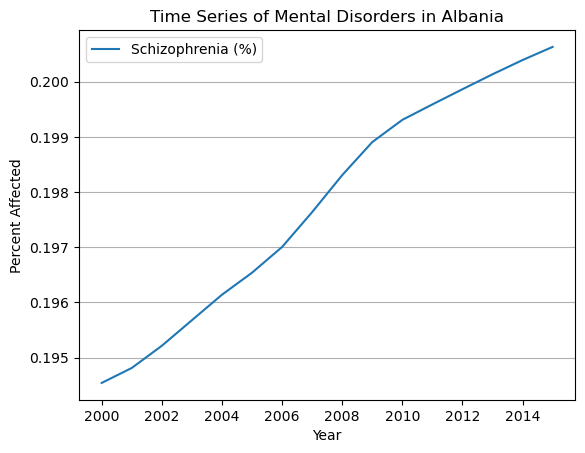

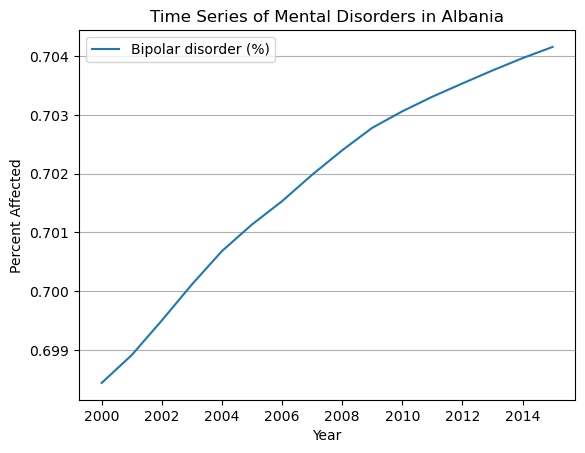

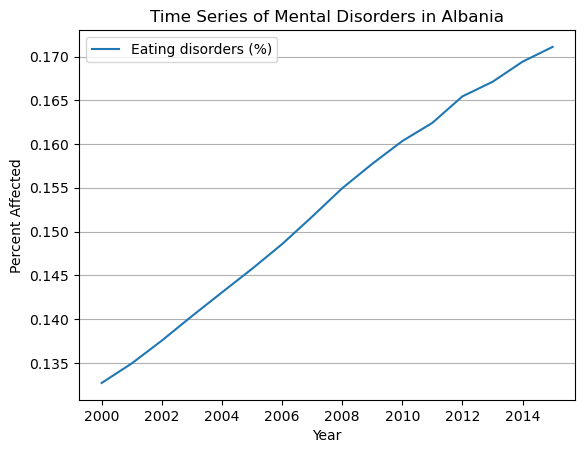

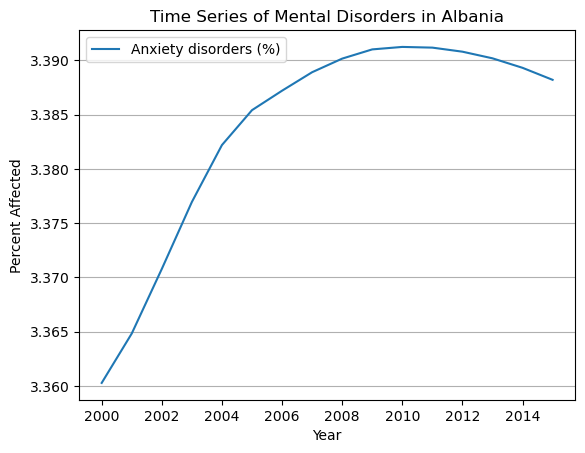

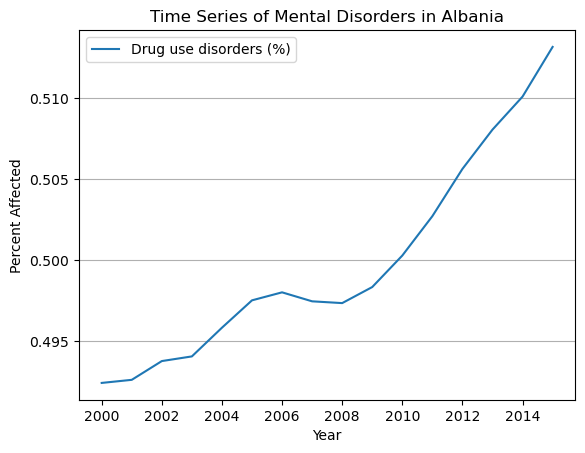

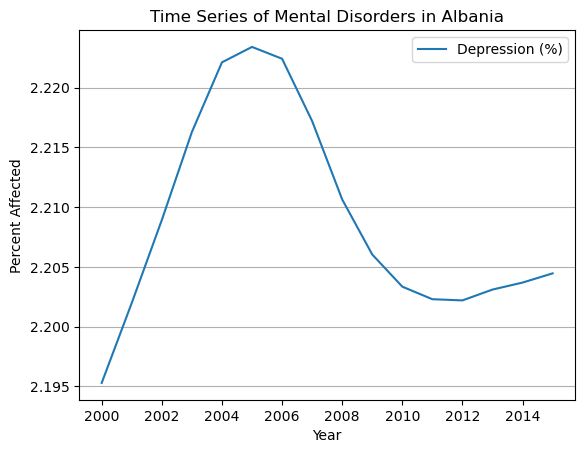

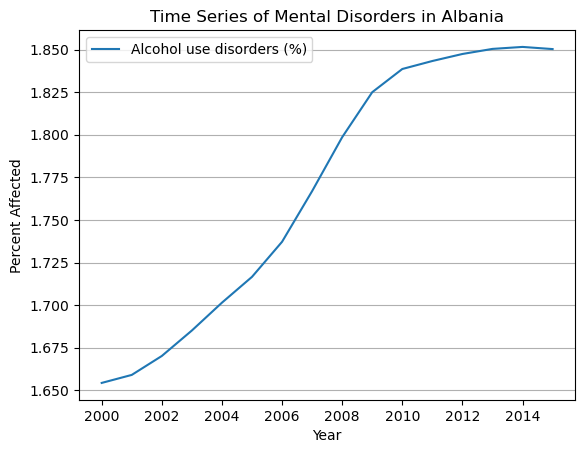

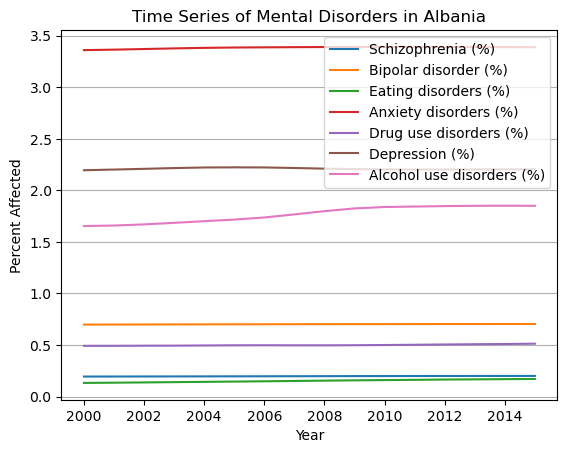

In [330]:
#Time series displaying the change in each mental disorder in Albania from 2000-2015
line_plot(final_df, 'Albania')
#Time series displaying the change in mental disorders in Albania from 2000-2015
line_plot_comb(final_df, 'Albania')

### Heatmap
The correlation heatmap consideres a specific year and compares all countries from our dataset across all possible variables that are considered for our project. From this heatmap, we can observe a correlations amongst multiple variables, including any variables that may behave in a similar fashion. For instance, alcohol use and umemployment rate are negatively correlated with every mental health disorder, and depression is negatively correlated with every variable. Alternatively, there are certain clusters that indicate similar trends, such as bipolar, eating disorder, and anxiety disorders all being positively correlated with each other. Furthermore, we can get a general idea of which variables have low correlation with mental heatlth disorers. For instance, life expectancy and HDI are minimally correlated with drug use, which indicates those variables may not be effective in modeling changes in drug use.  

In [331]:
#Function to create a heatmap based off year selected
def makeHeatmap(df, year):
    heatmap_data = df.iloc[:,1:]
    heatmap_data = heatmap_data[heatmap_data['Year'] == year]
    heatmap_data = heatmap_data.drop('Year', axis = 1)
    correlation_matrix = heatmap_data.corr()
    plt.figure(figsize=(6,4))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f'Correlation Heatmap for Mental Disorders in {year} Across Countries')
    plt.show()

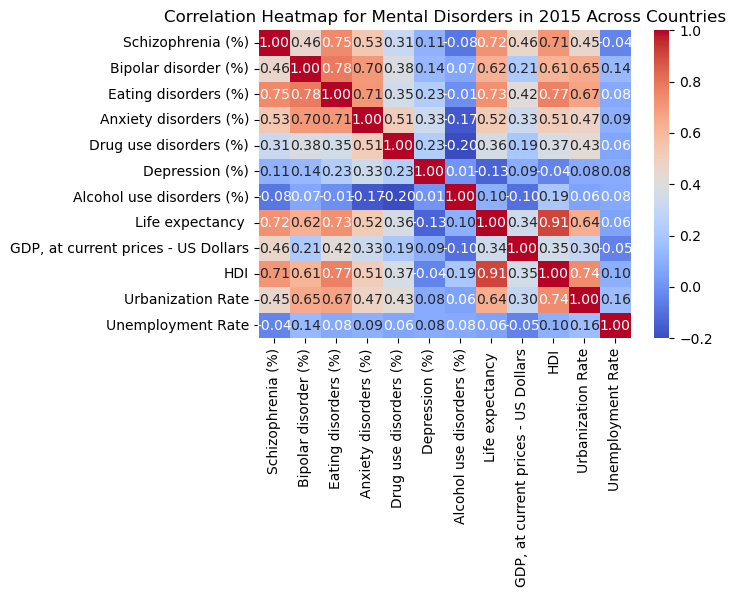

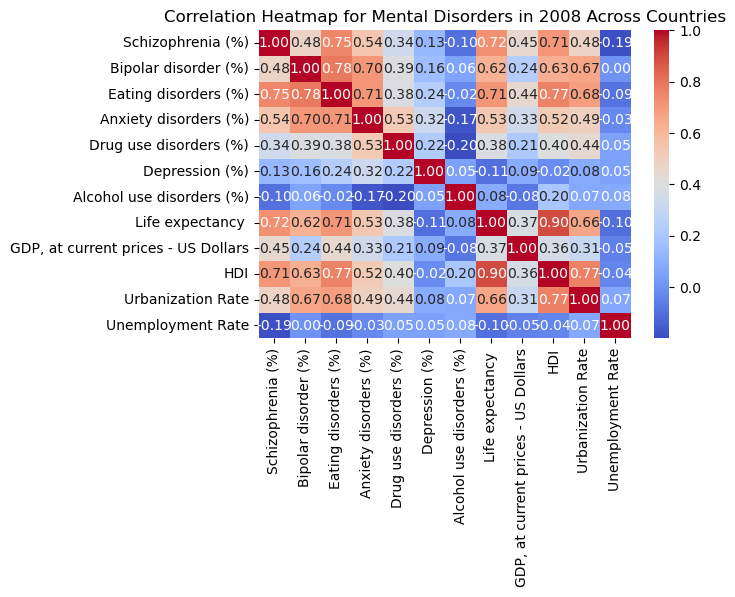

In [332]:
makeHeatmap(final_df, 2015)
makeHeatmap(final_df, 2008)

#### Scatterplot Matrix

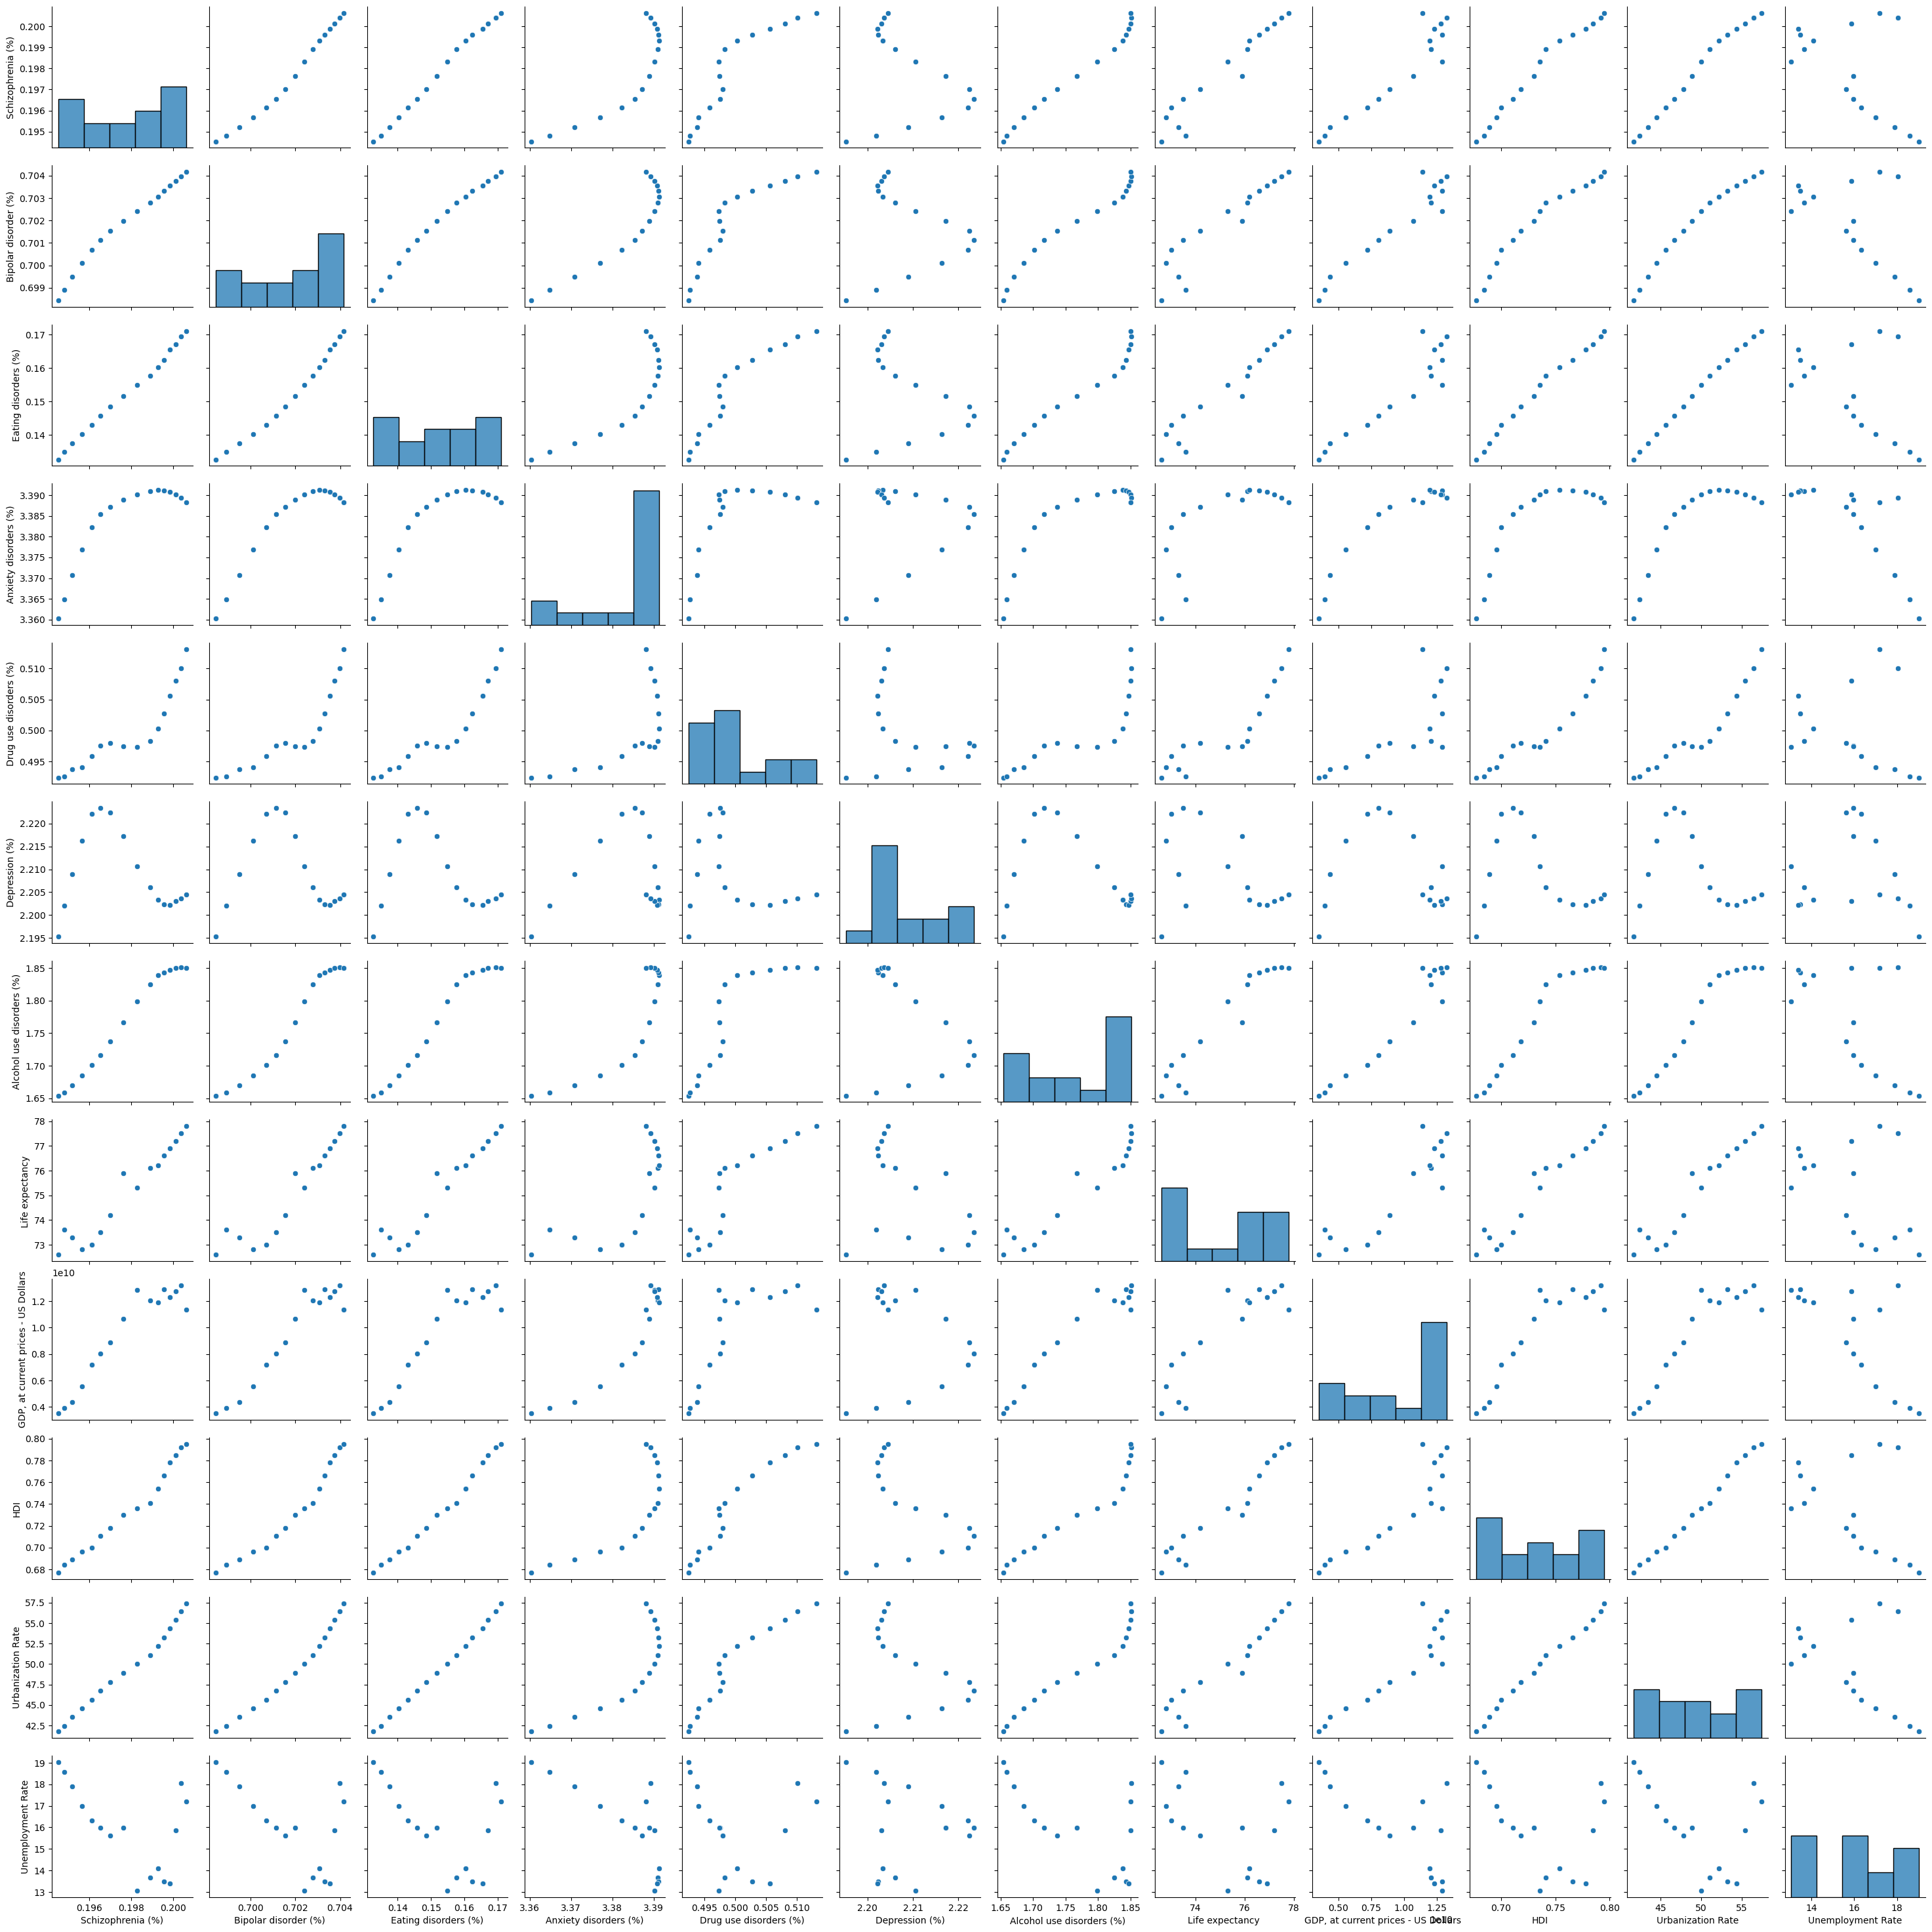

,Schizophrenia (%),Bipolar disorder (%),Eating disorders (%),Anxiety disorders (%),Drug use disorders (%),Depression (%),Alcohol use disorders (%),Life expectancy,"GDP, at current prices - US Dollars",HDI,Urbanization Rate,Unemployment Rate
16,0.194541,0.698437,0.132704,3.360267,0.492401,2.195285,1.654338,72.6,3.487586e+09,0.677,41.741,19.03
17,0.194812,0.698912,0.134932,3.364824,0.492592,2.201979,1.659040,73.6,3.926888e+09,0.684,42.435,18.58
18,0.195214,0.699501,0.137541,3.370780,0.493751,2.208921,1.670158,73.3,4.355866e+09,0.689,43.501,17.90
19,0.195677,0.700114,0.140335,3.376952,0.494039,2.216283,1.685102,72.8,5.561459e+09,0.696,44.573,16.99
20,0.196139,0.700683,0.143047,3.382199,0.495812,2.222116,1.701433,73.0,7.177030e+09,0.700,45.651,16.31


In [333]:
input_variables = ['Country','Year','Life expectancy ', 'GDP, at current prices - US Dollars',\
                   'HDI', 'Urbanization Rate', 'Unemployment Rate']
scatter_df= final_df[final_df['Year'] == 2015]
scatter_df= final_df[final_df['Country'].str.contains('Albania')]
scatter_df = scatter_df.drop(['Year', 'Country'], axis = 1)
sns.pairplot(scatter_df)
plt.show()
scatter_df.head()


## Data Limitations

**Data bias:**
 
 When we were cleaning the data and dropping NaNs, we realized there is unequal representation because some countries appear more frequently than others leading to a skewed distribution of data. 
This overrepresentation would limit the generalizability and validity of our findings and potentially leads to overlooking less-represented nations.

Additionally, this will affect the rankings and comparisons in our results because our data only represents 135 countries out of the 195 countries in the world excluding less known countries like Vanuatu, Tonga, Togo, Cabo Verde, etc. 

**Repetitiveness:**

Our dataset on life expectancy incorporates both GDP and population data for each year, which has the potential to significantly increase the size of the dataset, posing increased challenges in terms of data management and analysis, particularly when dealing with a sizable dataset.

Additionally, this could lead to redundancy. Given that the identical GDP and population data may be replicated for each corresponding life expectancy record, this has the potential to create inefficiencies in data storage and analytical processes.

**Mental health disorders could overlap:**

The global mental health disorders dataset contains categories that may overlap, since mental health disorders are not mutually exclusive. For instance, people with anxiety can also have depression. 

Mental health disorders may not necessarily exist in isolation, and individuals can simultaneously suffer from multiple disorders. This co-occurrence of mental health conditions presents several constraints that cause limitations when conducting analysis and interpreting results.

The original data we used, obtained from the global trends in mental health disorders dataset, consists of columns that provide details regarding the Entity, Country Code, Year, and various mental health conditions, including Schizophrenia, Bipolar Disorder, Eating Disorders, Anxiety Disorders, Drug Use Disorders, Depression, and Alcohol Use Disorders. However, it's important to note that this dataset doesn't accommodate the presence of that overlap among some of these disorders. As a result, distinguishing the individual influence of each disorder becomes challenging, and it may be problematic to identify whether the observed effects come from a single disorder or interactions among multiple disorders.

**Different countries have different metrics for identifying diseases:**

Different countries may use different standards and measures in the identification and diagnosis of diseases. These disparities can impact our analytical procedures and the way we interpret results, causing disparities in disease identification, which, in turn, can complicate cross-country comparisons and give rise to discrepancies in reported disease prevalence. Additionally, cultural and societal norms can further shape how individuals perceive and report symptoms, thus influencing their inclination to seek medical attention and self-reported data. For example, according to the National Institutes of Health, in the United States of America, an individual must have five depression symptoms every day, nearly all day, for at least 2 weeks while according to the National Library of Medicine, Kenyans diagnose depression with tobacco use and engagement in binge drinking.  


**Data Availability:**


In our initial raw data, not all years seamlessly align or fit perfectly with other datasets. As a result, we found it essential to refine the scope of our analysis and narrow the years down. For instance, the unemployment analysis dataset covers the years 1991 to 2021, while other datasets, such as the life expectancy dataset, has the years 2000 to 2015. This led us to concentrate on distinct years characterized by complete and dependable data.

The HDI dataset was from Human Development Reports by the United Nations Development Programme and this dataset was created for the purpose of providing high quality international statistics that are free and accessible for all. There is no reason to question the trustworthiness of this dataset because it is an international organization that would not have personal interests to fulfill if the data results were biased.

Hanna Yukhymenko created the Urbanization dataset with the purpose of answering the question of how the percentage of urban population has developed in different continents as well as finding out what the most urban country is through analyzing both percentage and total urban population. She got this information from The World Bank organization. Even though this information is from a trustworthy organization, Hanna Yukhymenko is from Switzerland and may have been biased when creating this dataset especially because it is comparing countries.

Anjali Pant, an Engineering student from India created the unemployment dataset with the purpose of analyzing why unemployment occurs. Anjali’s country, India, has a relatively stable unemployment rate across most years hence leading us to believe that this dataset could be trustworthy. Additionally, Anjali got this data from The World Bank Organization which is also an internationally recognized organization.

Kumarra Jarshi created the Life expectancy dataset for the purpose of putting into account the immunization and human development rates in relation to life expectancy considering demographic variables, income composition and mortality rates by formulating a regression model based on mixed effects model and multiple linear regression while considering data from a period of 2000 to 2015 for all the countries. We have no reason to question the trustworthiness of this dataset because it cited the World Health Organization (WHO) as the source of the accurate data. WHO uses standardized metrics to collect data.

## Preregistration Statements
**Hypothesis 1:** \
Null Hypothesis: There is no statistically significant difference in depression rates in the population between countries with a GDP lower than 500 billion and countries with a GDP of higher than 500 billion.

Alternative Hypothesis: The percentage of the population with depression of any given year is significantly higher in countries where the GDP is lower than 500 billion.

**Hypothesis 2:** \
Null Hypothesis: There is no statistically significant difference in anxiety disorders between countries with a greater decrease in unemployment rate.

Alternative Hypothesis: An increase in anxiety disorders is more common in countries with a decrease in unemployment rates, potentially reflecting the impact of economic stability on mental health.

- Note: We made a tiny error on the original hypothesis saying an increase in anxiety disorders is more common in countries with a DECREASE in unemployment rate. On phase four, we fixed that error and changed our hypothesis to an increase in anxiety disorders is more common in countries with an INCREASE in unemployment rates. 

**Hypothesis 3:** \
Null Hypothesis: None of the socioeconomic factors are able to predict any of the mental health disorder rates. 

Alternative Hypothesis:  The combined influence of every significant sociaeconomic factor (GDP, Life Expectancy, Urbanization Rate, HDI, Unemployment Rate) can help predict at least one of the mental health disorders. 

- Note: Hypothesis 3 was not preregistered but we believed it would be relevant for our project which is why we decided to include it.

## Data Analysis


## Hypothesis 1

Null Hypothesis: There is no statistically significant difference in depression rates in the population between countries with a GDP lower than 500 billion and countries with a GDP of higher than 500 billion.

Alternative Hypothesis: The percentage of the population with depression of any given year is significantly higher in countries where the GDP is lower than 500 billion.

Our first hypothesis investigated if countries with an average GDP of less than 500 billion between 2000 and 2015 have higher rates of depression. In our preregistration statement, we planned on setting GDP as a dummy input where 1 represented countries with an average GDP of 500 billion or more. Instead, we analyzed GDP as a range of values.  We first subsetted our final dataframe to create a new dataframe called final_gdp containing columns Country, Year, GDP, and Depression. 

In [334]:
#Subset the final_df to only include necessary columns (Country, Year, GDP, Depression)
columns_of_interest = ["Country", "Year", "GDP, at current prices - US Dollars", "Depression (%)"]
final_gdp = final_df[columns_of_interest]
#Create two new dataframes: One for instances of countries with GDP higher than 500 billion and 
#one for GDP lower than 500 billion

#Higher than 500 billion
final_gdp['GDP, at current prices - US Dollars'] = pd.to_numeric(final_gdp['GDP, at current prices - US Dollars'],\
                                                                 errors='coerce')
checkNans(final_gdp)
high_gdp = final_gdp.groupby('Country')['GDP, at current prices - US Dollars'].mean()
high_gdp = high_gdp[high_gdp >= 500_000_000_000].index
high_gdp = final_gdp[final_df['Country'].isin(high_gdp)]
checkNans(high_gdp)
print(high_gdp.head())

#Lower than 500 billion
low_gdp = final_gdp.groupby('Country')['GDP, at current prices - US Dollars'].mean()
low_gdp = low_gdp[low_gdp < 500_000_000_000].index
low_gdp = final_gdp[final_df['Country'].isin(low_gdp)]
checkNans(low_gdp)
print(low_gdp.head())


print(final_gdp.head())

No NaN values in the dataset.
No NaN values in the dataset.
       Country  Year  GDP, at current prices - US Dollars  Depression (%)
96   Australia  2000                         4.098360e+11        4.803224
97   Australia  2001                         3.910300e+11        4.823557
98   Australia  2002                         4.361134e+11        4.854392
99   Australia  2003                         5.600960e+11        4.892317
100  Australia  2004                         6.802164e+11        4.920486
No NaN values in the dataset.
       Country  Year  GDP, at current prices - US Dollars  Depression (%)
0  Afghanistan  2000                         3.342034e+09        4.118610
1  Afghanistan  2001                         3.598471e+09        4.121381
2  Afghanistan  2002                         4.141524e+09        4.124928
3  Afghanistan  2003                         4.729042e+09        4.125230
4  Afghanistan  2004                         5.388482e+09        4.126384
       Country  Year  

/var/folders/lm/njkpdpjx0fj4qf3qcrcnvnkr0000gn/T/ipykernel_8093/1845494041.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_gdp['GDP, at current prices - US Dollars'] = pd.to_numeric(final_gdp['GDP, at current prices - US Dollars'],\


## 1. Two Sample T-Test

In [335]:
#We can run a difference of means ttest to determine significance in depression rates 
#between high GDP countries and low GDP countries
t_stat, p_value = ttest_ind(high_gdp['Depression (%)'], low_gdp['Depression (%)'], equal_var=False)

# Display the results
print(f'T-statistic: {t_stat:.5}')
print(f'P-value: {p_value:.5}')

# Interpret the results
if p_value < 0.05:
    print('The difference in means is statistically significant.')
else:
    print('There is no significant difference in means.')

T-statistic: 4.6801
P-value: 4.5941e-06
The difference in means is statistically significant.


The pvalue is less than 0.05, which means there is a statistically significant difference between depression levels in countries with a high GDP and in countries with a low GDP. To get further statistical information regarding the relationship between gdp and depression, we can run an OLS regression. 

## 2. Linear Regression

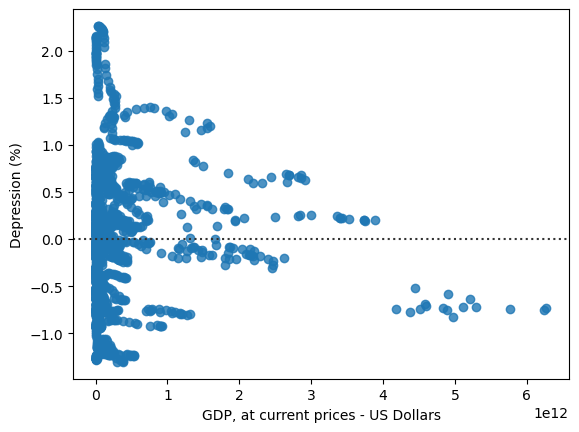

In [336]:
#Check for heteroskedasticity between Depression and GDP
sns.residplot(data=final_gdp, x = final_gdp["GDP, at current prices - US Dollars"], y = final_gdp['Depression (%)'])
plt.show()

The residual plots show that Depression (%) is not randomly distributed, and cluster closer to the lower end of the GDP scale. This means our data is heteroskedastic and we will need to transform the depression (%) values.

In [337]:
# Log transformation
final_gdp['Log_GDP'] = np.log(final_gdp['GDP, at current prices - US Dollars'])
final_df['Log_GDP'] = np.log(final_gdp['GDP, at current prices - US Dollars'])
print(final_gdp.head())

       Country  Year  GDP, at current prices - US Dollars  Depression (%)  \
0  Afghanistan  2000                         3.342034e+09        4.118610   
1  Afghanistan  2001                         3.598471e+09        4.121381   
2  Afghanistan  2002                         4.141524e+09        4.124928   
3  Afghanistan  2003                         4.729042e+09        4.125230   
4  Afghanistan  2004                         5.388482e+09        4.126384   

     Log_GDP  
0  21.929845  
1  22.003775  
2  22.144330  
3  22.276989  
4  22.407530  


/var/folders/lm/njkpdpjx0fj4qf3qcrcnvnkr0000gn/T/ipykernel_8093/1851573616.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_gdp['Log_GDP'] = np.log(final_gdp['GDP, at current prices - US Dollars'])


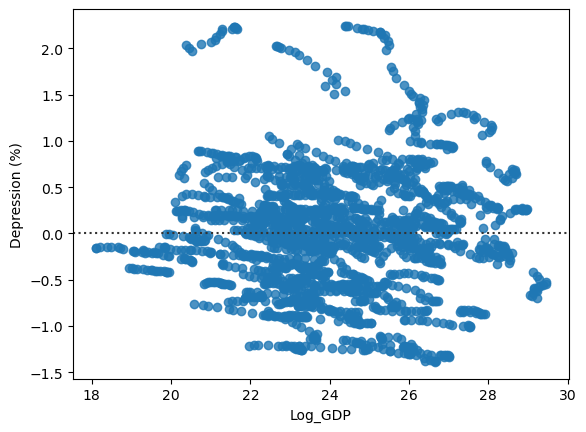

In [338]:
#Re-check for heteroskedasticity with transformed values
sns.residplot(data=final_gdp, x=final_gdp["Log_GDP"], y=final_gdp['Depression (%)'])
plt.show()

The regraphed residual plot displays a random distribution around the x-axis between log transformed GDP values
and GDP rates.

In [339]:
# Run an Ordinary Least Squares Regression
# Separate predictors (X) and target variable (y)
X = final_gdp[['Log_GDP']]
y = final_gdp['Depression (%)'] 

# Add a constant term to the predictor matrix
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

# Print the intercept, coef, and regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Depression (%)   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     32.22
Date:                Thu, 16 Nov 2023   Prob (F-statistic):           1.57e-08
Time:                        20:06:53   Log-Likelihood:                -2120.7
No. Observations:                2152   AIC:                             4245.
Df Residuals:                    2150   BIC:                             4257.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5744      0.162     15.853      0.0

The OLS Regression Results displays a p value rounded to 0, which is less than 0.05 so we can reject the null hypothesis and conclude that a high GDP is associated with depression rates. 
Furthermore, the confindence interval for high_gdp doesn't include 0, which indicates that 95% of β values is between 0.025 and 0.051, so this indicates that gdp has an effect in the positive direction on the depression rates, whereas our alternative hypothesis states that there would be an increase in depression in lower GDP countries.
Thus, in order to further confirm this, we can run a linear regression.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The regression coefficient is: [0.03797762]
The intercept is: [2.57435476]


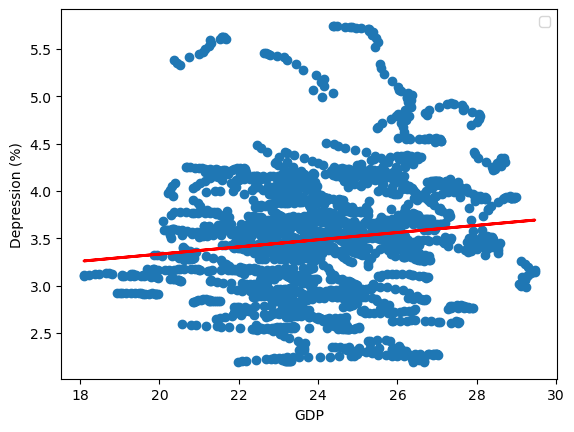

In [340]:
#Run a Linear Regression
#final_gdp['Log_GDP'] = pd.to_numeric(final_gdp['Log_GDP'], errors='coerce')
#final_gdp['Depression (%)'] = pd.to_numeric(final_gdp['Depression (%)'], errors='coerce')

x = final_gdp[["Log_GDP"]]
y = final_gdp[["Depression (%)"]]

linmodel = LinearRegression().fit(x,y)
yhat = linmodel.predict(x)

print(f"The regression coefficient is: {linmodel.coef_[0]}")
print(f"The intercept is: {linmodel.intercept_}")

#Plot as scatterplot
plt.scatter(x, y)

# Plotting the regression line
plt.plot(x, yhat, color='red', linewidth=2)

# Adding labels and title
plt.xlabel('GDP')
plt.ylabel('Depression (%)')
plt.legend()

# Show the plot
plt.show()

We ran a linear regression of the transformed GDP values to calculate the regression coefficient of Depression (%). 
The regression coefficient means that for a 1% change in GDP, there is a 0.003797762 change in depression. 
The intercept tells tus that when GDP is 0 for any given country, the expected Depression (%) is 2.574.

## Permutation
To determine if the 0.03797762 actually represents a relationship between GDP and depression levels, we can permute the GDP and Depression columns. 

The percentage of values greater than the observed slope 0.03797762 is: 0.0%


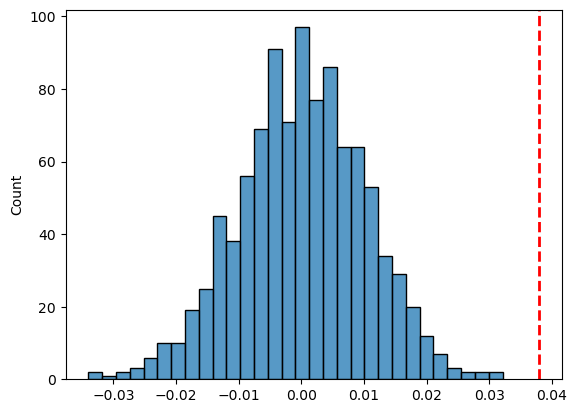

In [341]:
#Sample random pairs
X_1000 = final_gdp["Log_GDP"].sample(n=1000)
Y_1000 = final_gdp["Depression (%)"].sample(n=1000)
permutation_slopes = np.zeros(1000)
for i in range(1000):
    permuted_X = np.random.choice(X_1000, 1000, replace=False)
    df = pd.DataFrame({"X": permuted_X, "Y": Y_1000})
    model = LinearRegression().fit(df[["X"]], df["Y"])
    permutation_slopes[i] = model.coef_[0]

sns.histplot(permutation_slopes, bins=30)
plt.axvline(0.03797762, color='red', linestyle='dashed', linewidth=2)

greater_than_observed_slope = sum(slope > 0.03797762 for slope in permutation_slopes)
percentile_observed = (greater_than_observed_slope / len(permutation_slopes)) * 100

print(f"The percentage of values greater than the observed slope 0.03797762 is: {percentile_observed}%")

After running a permutation with 1000 sample values of our gdp and depression data, we compared our observed regression slope to the permuted slope values. Both our histogram and percentile calculations show that our observed value is in the 99th percentile, which means that it is highly significant and GDP has an observed impact on depression rates. 

## Hypothesis 2

Hypothesis 2:
An increase in anxiety disorders is more common in countries with an increase in unemployment rates, potentially reflecting the impact of economic stability on mental health. 

Null Hypothesis:
	There is no statistically significant difference in anxiety disorders between countries with a greater decrease in unemployment rate. 
    
Analysis 2:
Identify countries that see an average decrease in unemployment rate from 2000-2015. Run a linear regression that sets the input to be the average decrease in unemployment rate and the output to be the change in anxiety disorders of those countries. A statistically significant positive or negative coefficient for unemployment rates will support the hypothesis, suggesting that unemployment rates have an impact on anxiety disorder prevalence.


Null Hypothesis:
	There is no statistically significant difference in anxiety disorders between countries with a greater decrease in unemployment rate.

Alternative Hypothesis:
    An increase in anxiety disorders is more common in countries with a decrease in unemployment rates, potentially reflecting the impact of economic stability on mental health. 
    
- Note: We made a tiny error on the original hypothesis saying an increase in anxiety disorders is more common in countries with a DECREASE in unemployment rate. On phase four, we fixed that error and changed our hypothesis to an increase in anxiety disorders is more common in countries with a DECREASE in unemployment rates. 
    

In [342]:
#First step is to calculate the slope of unemployment rate in countries from 2000 upto 2015 and see which countries 
#have a positive slope showing an increase in unemployment rate

#subset data to just include country, year and unemployment rate
df_unemployment = final_df[['Country', 'Year','Unemployment Rate']]
df_unemployment.head()


# Pivot the data to have years as columns
pivoted_unemploy = df_unemployment.pivot(index='Country', columns='Year', values='Unemployment Rate')

# Create a new DataFrame to store the slopes
slopes_df = pd.DataFrame(index=pivoted_unemploy.index, columns=['Slope'])

# Fit a linear regression model for each country and store the slope
for country in pivoted_unemploy.index:
    y = pivoted_unemploy.loc[country].values
    X = sm.add_constant(range(len(y)))  # Add a constant term for the intercept
    model = sm.OLS(y, X).fit()
    slopes_df.loc[country, 'Slope'] = model.params[1]  # The slope coefficient


slopes_df.head()

# Filter countries with a positive slope, indicating an increasing trend
countries_with_increasing_rate = slopes_df[slopes_df['Slope'] > 0].index


print("Countries with a increasing unemployment rate trend:")
print(countries_with_increasing_rate.tolist())


Countries with a increasing unemployment rate trend:
['Afghanistan', 'Angola', 'Armenia', 'Austria', 'Bahrain', 'Bangladesh', 'Barbados', 'Belgium', 'Benin', 'Burkina Faso', 'Canada', 'Chad', 'Comoros', 'Costa Rica', 'Croatia', 'Cyprus', 'Denmark', 'Dominican Republic', 'Fiji', 'France', 'Gabon', 'Georgia', 'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras', 'Hungary', 'Iceland', 'Iraq', 'Ireland', 'Italy', 'Kuwait', 'Latvia', 'Luxembourg', 'Malawi', 'Maldives', 'Mauritania', 'Mexico', 'Mozambique', 'Myanmar', 'Nepal', 'Netherlands', 'New Zealand', 'Pakistan', 'Portugal', 'Rwanda', 'Samoa', 'Saudi Arabia', 'Senegal', 'Serbia', 'Sierra Leone', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Tunisia']


In [343]:
#The second step is to subset the original dataframe so that we have two separate dataframes, one with increasing 
#unemplyment rates and another with decreasing unemployment rates through the years.

# Create subsets for countries with increasing and decreasing unemployment rates
unemploy_increasing = final_df[final_df['Country'].isin(countries_with_increasing_rate)]
unemploy_decreasing = final_df[~final_df['Country'].isin(countries_with_increasing_rate)]

print(unemploy_increasing.head())


       Country  Year  Schizophrenia (%)  Bipolar disorder (%)  \
0  Afghanistan  2000           0.161621              0.700015   
1  Afghanistan  2001           0.161957              0.700499   
2  Afghanistan  2002           0.162414              0.701141   
3  Afghanistan  2003           0.162916              0.701860   
4  Afghanistan  2004           0.163377              0.702556   

   Eating disorders (%)  Anxiety disorders (%)  Drug use disorders (%)  \
0              0.086021               4.827047                1.788395   
1              0.086517               4.831409                1.839123   
2              0.087023               4.838318                1.934326   
3              0.087189               4.845538                2.051106   
4              0.088158               4.851512                2.163044   

   Depression (%)  Alcohol use disorders (%)  Life expectancy   \
0        4.118610                   0.662479              54.8   
1        4.121381               

## 1. Two Sample T-Test

In [344]:
#We can then perform two sample t-test to compare the means of the two groups. 
#The null hypothesis (H0) assumes that there is no significant difference between the means of the two groups.
#The alternative hypothesis (HA) assumes that there is a significant difference between the means of the two groups.

# Perform a two-sample t-test
t_stat, p_value = ttest_ind(unemploy_increasing['Anxiety disorders (%)'],\
                            unemploy_decreasing['Anxiety disorders (%)'], equal_var=False)

print(f'T-test statistic: {t_stat}')
print(f'P-value: {p_value}')

# Determine statistical significance
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis. There is a statistically significant difference in means.')
else:
    print('Fail to reject the null hypothesis. There is no statistically significant difference in means.')

T-test statistic: 7.219678941273232
P-value: 7.505187905330805e-13
Reject the null hypothesis. There is a statistically significant difference in means.


### Analysis

Based on the t-test we ran, we can see that the p-value is less than 0.05. That means we reject the null, and there is a significant difference in the mean percentage of anxiety disorders in countries with increasing unemployment rate and countries with decreasing unemployment rate. Now let us try and understand that difference by using visualizations and descriptive statistics.


In [345]:
# Descriptive statistics
stats_increasing = unemploy_increasing['Anxiety disorders (%)'].describe()
stats_decreasing = unemploy_decreasing['Anxiety disorders (%)'].describe()

print("Descriptive Statistics - Increasing Unemployment Rate:")
print(stats_increasing)
print("\nDescriptive Statistics - Decreasing Unemployment Rate:")
print(stats_decreasing)


Descriptive Statistics - Increasing Unemployment Rate:
count    928.000000
mean       4.208201
std        1.244647
min        2.586238
25%        3.236940
50%        3.800763
75%        5.235774
max        8.967330
Name: Anxiety disorders (%), dtype: float64

Descriptive Statistics - Decreasing Unemployment Rate:
count    1224.000000
mean        3.830980
std         1.139386
min         2.503303
25%         2.952021
50%         3.464512
75%         4.481682
max         7.649241
Name: Anxiety disorders (%), dtype: float64


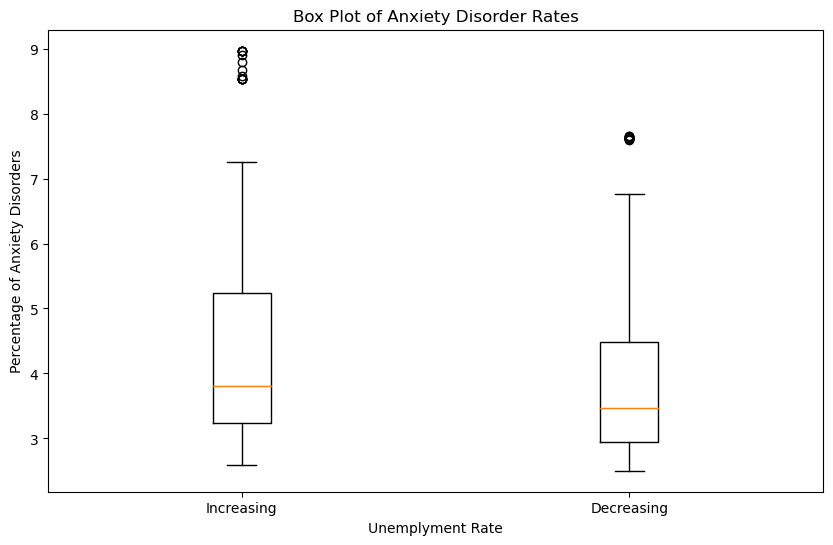

In [346]:
# Box plots
plt.figure(figsize=(10, 6))
plt.boxplot([unemploy_increasing['Anxiety disorders (%)'], unemploy_decreasing['Anxiety disorders (%)']], \
            labels=['Increasing', 'Decreasing'])
plt.title('Box Plot of Anxiety Disorder Rates')
plt.ylabel('Percentage of Anxiety Disorders')
plt.xlabel('Unemplyment Rate')
plt.show()

### Analysis

From the descriptive statistics and the box plot, we can see that the mean percentage anxiety disorder for countries with increasing unemployment rate(4.208201) is higher than countries with decreasing unemployment rate(3.830980). 


## 2. Linear Regression

We can also run regression to see the relationship between increasing unemployment rate and anxiety disorders. But first, let us check for heteoskedasticity by making a residual plot for unemployment rate and anxiety disorders rates.


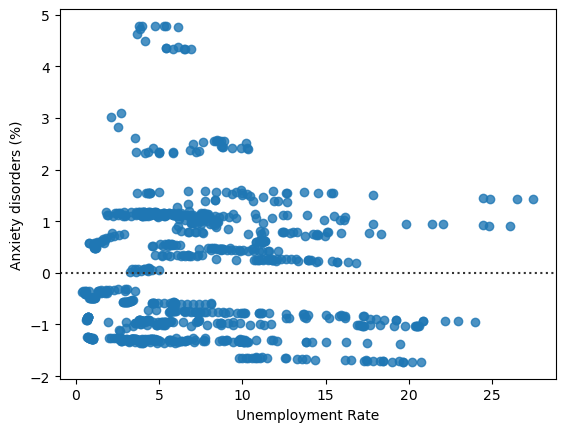

In [347]:
sns.residplot(data=unemploy_increasing, x = unemploy_increasing["Unemployment Rate"], \
              y = unemploy_increasing['Anxiety disorders (%)'])
plt.show()

We can see that the residual plot shows a relatively random distribution showing a linear relationship between unemployment rate and percentage of anxiety disorders. There is no need for transformation so we can go ahead with our linear regression for countries with increasing unemployment rate.


In [348]:
# Define dependent and independent variables

y = unemploy_increasing['Anxiety disorders (%)']
X = unemploy_increasing[['Unemployment Rate']]

# Add a constant term to the predictor matrix
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(y, X).fit()

print(model.summary())


                              OLS Regression Results                             
Dep. Variable:     Anxiety disorders (%)   R-squared:                       0.001
Model:                               OLS   Adj. R-squared:                  0.000
Method:                    Least Squares   F-statistic:                     1.077
Date:                   Thu, 16 Nov 2023   Prob (F-statistic):              0.300
Time:                           20:07:15   Log-Likelihood:                -1518.8
No. Observations:                    928   AIC:                             3042.
Df Residuals:                        926   BIC:                             3051.
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const   

### Analysis

We can interpret this as for every 1 unit increase in unemployment rate, the rate of anxiety disorders increases by 0.0085. 


## Permutation
To determine if the 0.0085 actually represents a relationship between increasing unemployment rate and depression levels, we can permute those columns.


The percentage of values greater than the observed slope (0.0085) is: 17.8%


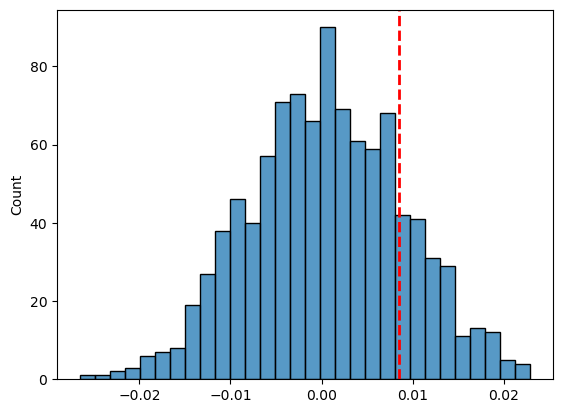

In [349]:
#Sample random pairs
X_100 = unemploy_increasing["Unemployment Rate"].sample(n=900)
Y_100 = unemploy_increasing["Anxiety disorders (%)"].sample(n=900)
permutation_slopes = np.zeros(1000)
for i in range(1000):
    permuted_X = np.random.choice(X_100, 900, replace=False)
    df = pd.DataFrame({"X": permuted_X, "Y": Y_100})
    model = LinearRegression().fit(df[["X"]], df["Y"])
    permutation_slopes[i] = model.coef_[0]
sns.histplot(permutation_slopes, bins=30)
plt.axvline(0.0085, color='red', linestyle='dashed', linewidth=2)

greater_than_observed_slope = sum(slope > 0.0085 for slope in permutation_slopes)
percentile_observed = (greater_than_observed_slope  / len(permutation_slopes)) * 100

print(f"The percentage of values greater than the observed slope ({0.0085}) is: {percentile_observed}%")


Our objective was to see the red dashed line towards the right tail of the distribution. However, having only around 15.8% of values greater than the observed slope suggests that the observed relationship may not be significantly stronger or more positive than what random chance would produce. That means although we see a positive relationship between increasing unemployment rate and anxiety disorders, based on the data we have, this might have happened due to random chance and not necessarily due to the existence of a positive relationship.

## Hypothesis 3

Null Hypothesis: None of the socioeconomic factors are able to predict any of the mental health disorder rates. 

Alternative Hypothesis:  The combined influence of every significant socioeconomic factor (GDP, Life Expectancy, Urbanization Rate, HDI, Unemployment Rate) can help predict at least one of the mental health disorders. 

- Note: Hypothesis 3 was not preregistered but we believed it would be relevant for our project which is why we decided to include it.

## 1. OLS Regression

We have our independent variables ('Life expectancy ', 'GDP, at current prices - US Dollars', 'HDI', 'Urbanization Rate', 'Unemployment Rate') and our dependent variables ('Schizophrenia (%)', 'Bipolar disorder (%)','Eating disorders (%)', 'Anxiety disorders (%)','Drug use disorders (%)', 'Depression (%)', 'Alcohol use disorders (%)'). 
Since we have multiple predictor variables, there is a high risk of multicollinearity where there independent variables could be highly correlated with each other. So before we run our OLS regression, we will run a multicollinearity test.

In [350]:
#Check for multicollinearity between independent variables by running a correlation matrix


independent_vars = ['Life expectancy ', 'GDP, at current prices - US Dollars', 'HDI',\
                    'Urbanization Rate', 'Unemployment Rate']
dependent_vars = ['Schizophrenia (%)', 'Bipolar disorder (%)',\
                  'Eating disorders (%)', 'Anxiety disorders (%)',\
                  'Drug use disorders (%)', 'Depression (%)', 'Alcohol use disorders (%)']

correlation_matrix = final_df[independent_vars].corr()
correlation_matrix

,Life expectancy,"GDP, at current prices - US Dollars",HDI,Urbanization Rate,Unemployment Rate
Life expectancy,1.000000,0.332307,0.898948,0.663750,-0.004823
"GDP, at current prices - US Dollars",0.332307,1.000000,0.342984,0.289928,-0.041599
HDI,0.898948,0.342984,1.000000,0.765155,0.076858
Urbanization Rate,0.663750,0.289928,0.765155,1.000000,0.132644
Unemployment Rate,-0.004823,-0.041599,0.076858,0.132644,1.000000


### Interpretation

- Life expectancy has a moderate to strong positive correlation with HDI (0.898), Urbanization Rate (0.664), and a weaker positive correlation with GDP (0.332).
- GDP has a weak to moderate positive correlation with HDI (0.343), Urbanization Rate (0.290), and a weak negative correlation with Unemployment Rate (-0.042).
- HDI has a strong positive correlation with Life expectancy (0.899) and Urbanization Rate (0.765), and a moderate positive correlation with GDP (0.343).
- Urbanization Rate has moderate to strong positive correlations with Life expectancy (0.664), HDI (0.765), and a weak positive correlation with GDP (0.290) and Unemployment Rate (0.133).
- Unemployment Rate shows very weak correlations with the other variables: weak negative correlation with GDP (-0.042) and weak positive correlation with Urbanization Rate (0.133).


High correlations among predictors might indicate multicollinearity, which can affect the stability and interpretation of the regression coefficients. We will then check the variance inflation factor (VIF) for each predictor to quantify the severity of multicollinearity. If multicollinearity is detected (VIF values greater than 5 or 10), we plan to deal with it by removing highly correlated predictors.

In [351]:
# Select only the predictor variables (independent variables)
predictors = final_df[['Life expectancy ', 'GDP, at current prices - US Dollars', 'HDI', \
                       'Urbanization Rate', 'Unemployment Rate']]

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = predictors.columns
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]
vif_data

,Variable,VIF
0,Life expectancy,63.558587
1,"GDP, at current prices - US Dollars",1.270388
2,HDI,5.495490
3,Urbanization Rate,2.456152
4,Unemployment Rate,0.987415


### Interpretation
- Life expectancy: A VIF of 63.56 indicates extremely high multicollinearity with other variables. This high VIF suggests that 'Life expectancy' is highly correlated with one or more other predictor variables in our model.

- GDP, at current prices - US Dollars: A VIF of 1.27 suggests low multicollinearity. This variable has minimal correlation with other predictors in the model.

- HDI (Human Development Index): With a VIF of 5.50, this variable exhibits moderate multicollinearity. While not as high as 'Life expectancy', it indicates a notable correlation with other predictors.

- Urbanization Rate: The VIF of 2.46 also indicates moderate multicollinearity, signifying a moderate correlation with other variables.

- Unemployment Rate: The VIF of 0.99 suggests low multicollinearity, indicating minimal correlation with other predictors in the model.



Since Life expectancy and HDI have the highest multicollinearity, we will remove them when we run our linear regression. Our next step is to make residual plots to check for any kind of heteroskedasticity amongst our variables.

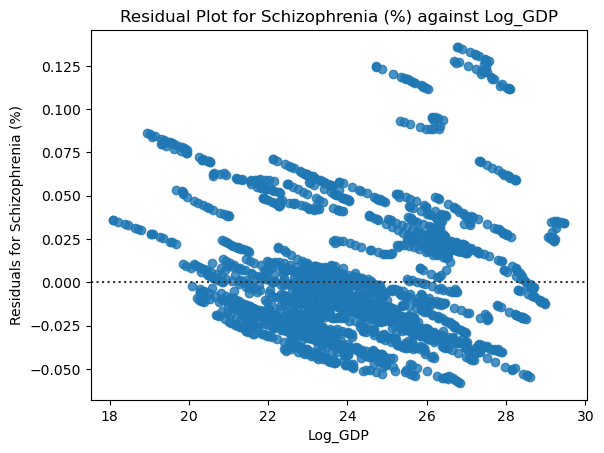

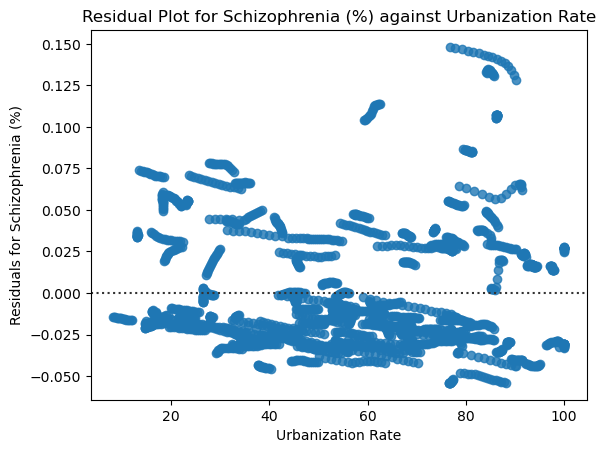

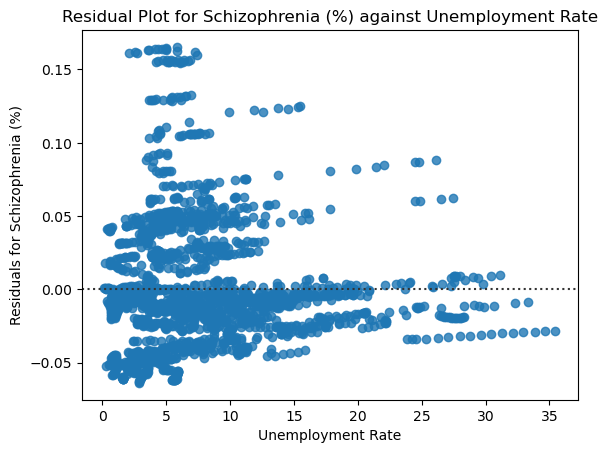

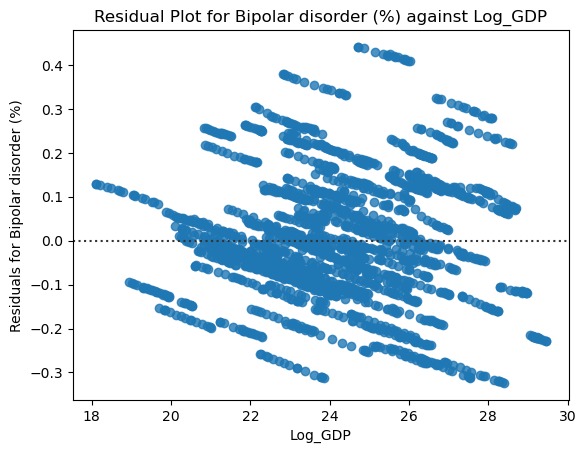

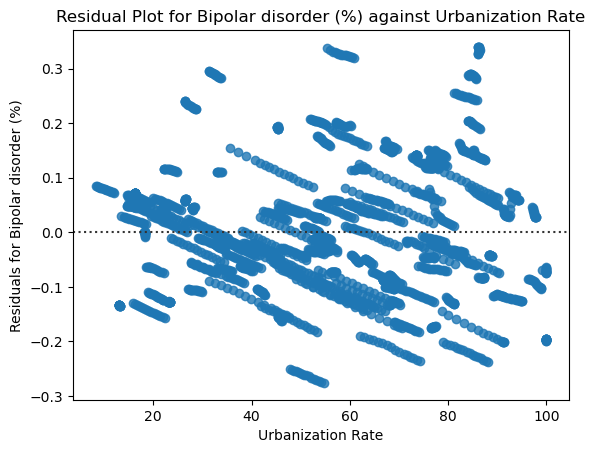

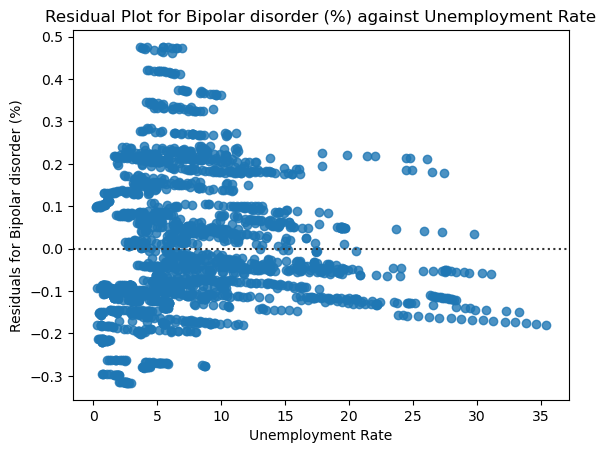

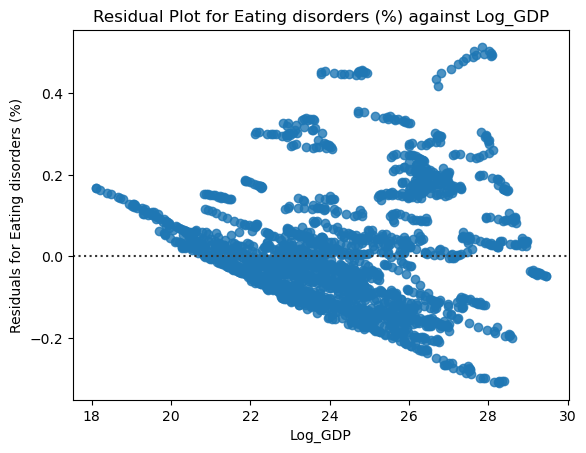

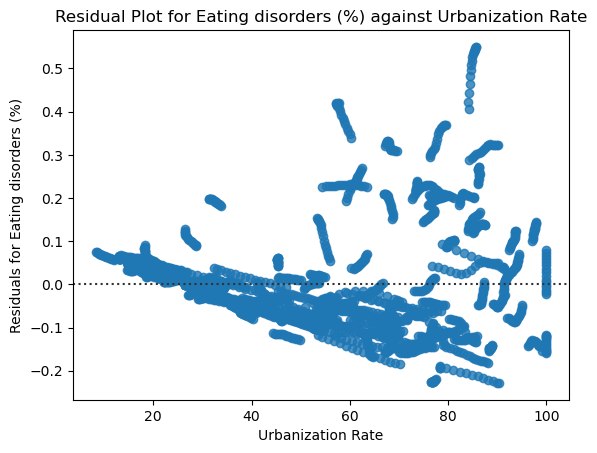

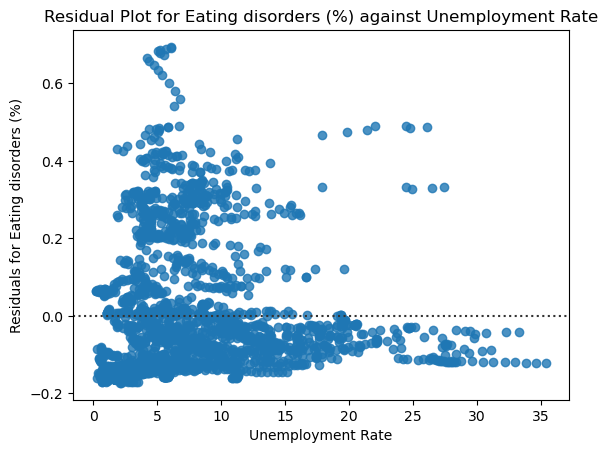

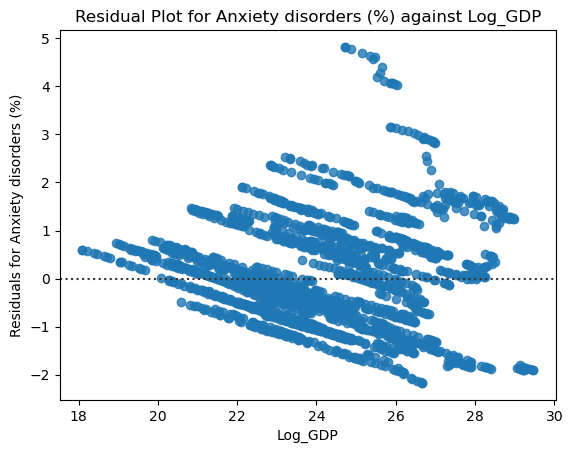

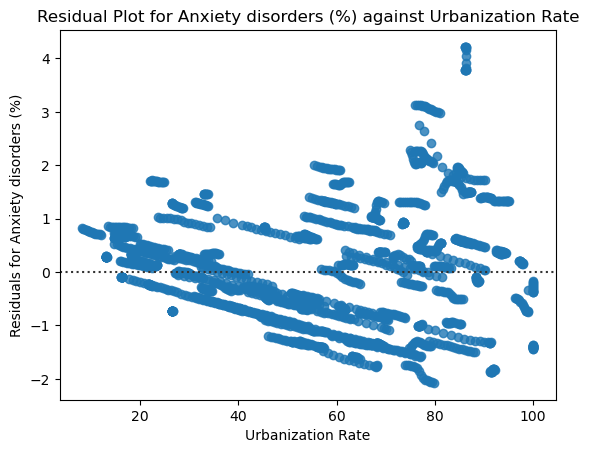

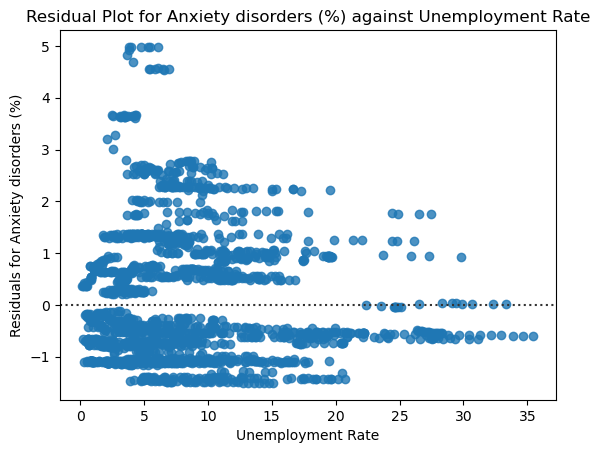

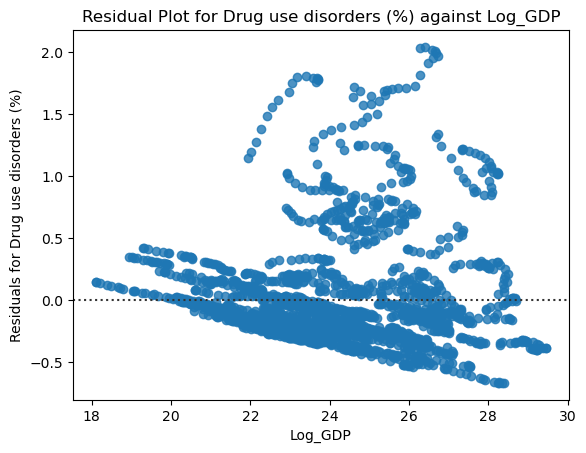

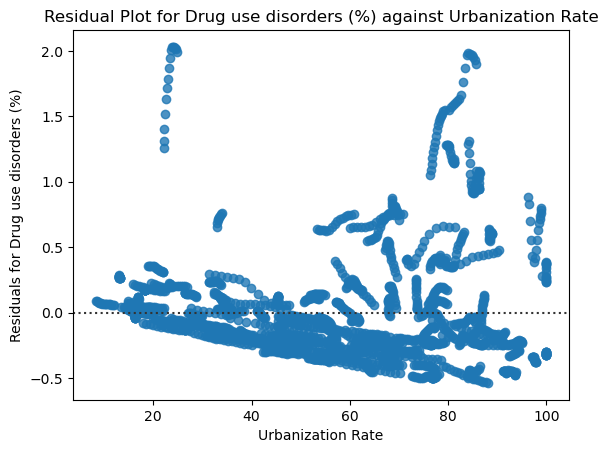

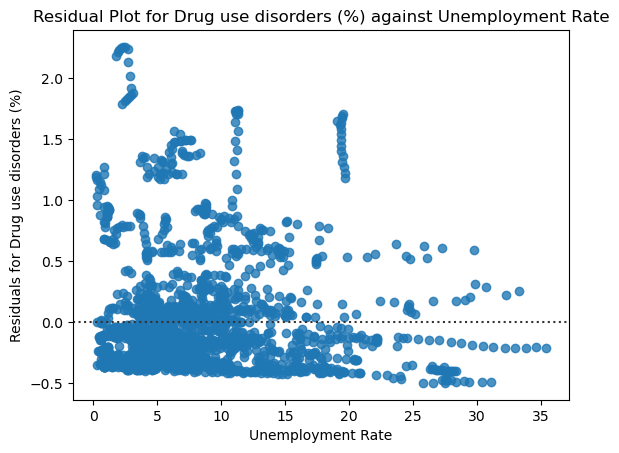

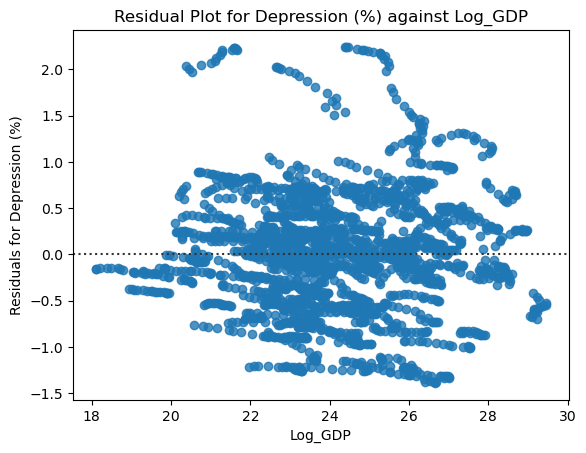

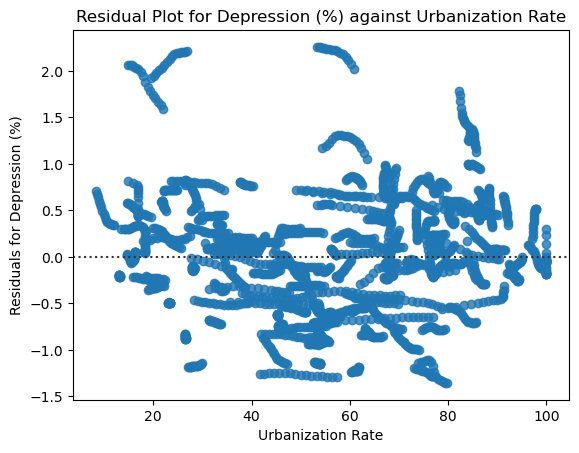

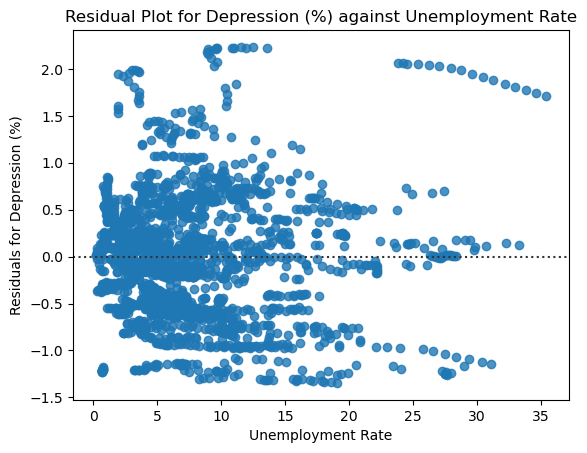

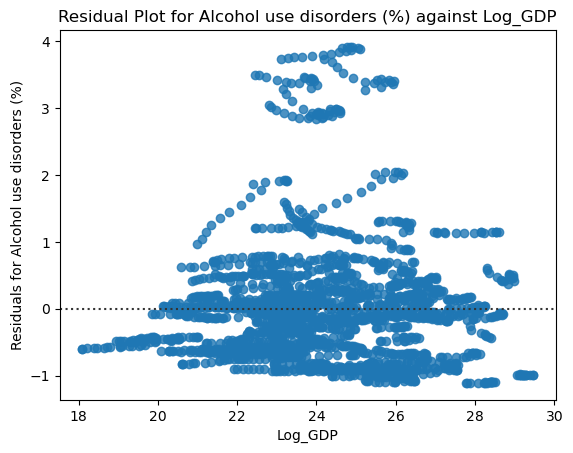

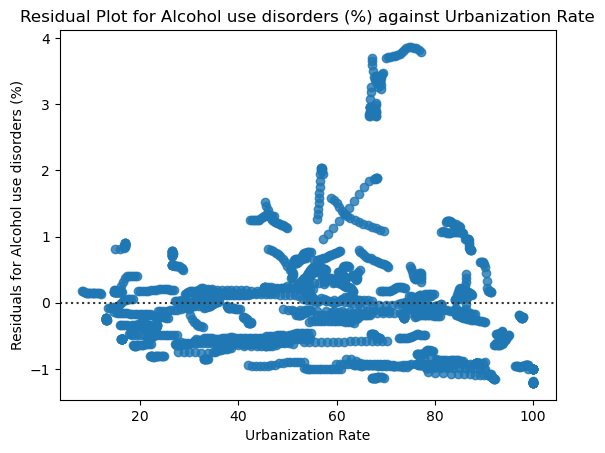

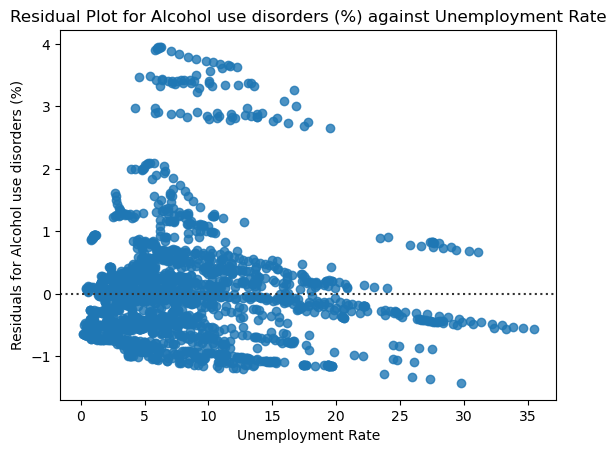

In [352]:
#Residual Plots

independent_vars = ['Log_GDP', 'Urbanization Rate', 'Unemployment Rate']
dependent_vars = ['Schizophrenia (%)', 'Bipolar disorder (%)',\
                  'Eating disorders (%)', 'Anxiety disorders (%)',\
                  'Drug use disorders (%)', 'Depression (%)', 'Alcohol use disorders (%)']

for dependent_var in dependent_vars:
    for independent_var in independent_vars:
        if dependent_var != independent_var:  # Exclude plotting a variable against itself
            sns.residplot(data=final_df, x=final_df[independent_var], y=final_df[dependent_var])
            plt.xlabel(independent_var)
            plt.ylabel(f"Residuals for {dependent_var}")
            plt.title(f"Residual Plot for {dependent_var} against {independent_var}")
            plt.show()
    

Now that we have checked for heteroskedasticity, we can run our linear regression on our independent and dependent variables.

In [353]:
independent_vars = ['Log_GDP', 'Urbanization Rate', 'Unemployment Rate']
dependent_vars = ['Schizophrenia (%)', 'Bipolar disorder (%)',\
                  'Eating disorders (%)', 'Anxiety disorders (%)',\
                  'Drug use disorders (%)', 'Depression (%)', 'Alcohol use disorders (%)']

for dependent_var in dependent_vars:
    X = final_df[independent_vars]
    y = final_df[dependent_var]
    X = sm.add_constant(X)  # Add a constant term
    model = sm.OLS(y, X).fit()  # Fit the OLS model
    print(f"Regression results for {dependent_var}:")
    print(model.summary())  # Print the summary
    print("\n")

Regression results for Schizophrenia (%):
                            OLS Regression Results                            
Dep. Variable:      Schizophrenia (%)   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     428.4
Date:                Thu, 16 Nov 2023   Prob (F-statistic):          4.35e-218
Time:                        20:07:23   Log-Likelihood:                 4243.5
No. Observations:                2152   AIC:                            -8479.
Df Residuals:                    2148   BIC:                            -8456.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

### Interpretation

We can see that all p-values are les than 0.05, showing that the combined socioeconomic factors have a significant relationship with mental health disorder rates. 

Schizophrenia (%)
- For one unit increase Log GDP, there is a 0.0085 increase in percentage of Schizophrenia.
- For one unit increase in Urbanization Rate, there is a 0.0005 increase in percentage of Schizophrenia.
- For one unit increase in Unemployment Rate, there is a 0.0009 increase in percentage of Schizophrenia.

Bipolar disorder (%):
- For one unit increase in Log GDP, there is an expected increase of 0.0093 in the percentage of Bipolar disorder.
- For one unit increase in Urbanization Rate, there is an expected increase of 0.0039 in the percentage of Bipolar disorder.
- There is no significant effect observed for a one unit increase in Unemployment Rate on the percentage of Bipolar disorder.

Eating disorders (%):
- For one unit increase in Log GDP, there is an expected increase of 0.0254 in the percentage of Eating disorders.
- For one unit increase in Urbanization Rate, there is an expected increase of 0.0037 in the percentage of Eating disorders.
- For one unit increase in Unemployment Rate, there is an expected decrease of 0.0016 in the percentage of Eating disorders.

Anxiety disorders (%):
- For one unit increase in Log GDP, there is an expected increase of 0.1715 in the percentage of Anxiety disorders.
- For one unit increase in Urbanization Rate, there is an expected increase of 0.0168 in the percentage of Anxiety disorders.
- There is no significant effect observed for a one unit increase in Unemployment Rate on the percentage of Anxiety disorders.

Drug use disorders (%):
- For one unit increase in Log GDP, there is an expected increase of 0.0433 in the percentage of Drug use disorders.
- For one unit increase in Urbanization Rate, there is an expected increase of 0.0066 in the percentage of Drug use disorders.
- There is no significant effect observed for a one unit increase in Unemployment Rate on the percentage of Drug use disorders.

Depression (%):
- For one unit increase in Log GDP, there is an expected increase of 0.0360 in the percentage of Depression.
- For one unit increase in Urbanization Rate, there is an expected increase of 0.0005 in the percentage of Depression.
- For one unit increase in Unemployment Rate, there is an expected increase of 0.0050 in the percentage of Depression.

Alcohol use disorders (%):
- For one unit increase in Log GDP, there is an expected decrease of 0.0122 in the percentage of Alcohol use disorders.
- For one unit increase in Urbanization Rate, there is an expected increase of 0.0026 in the percentage of Alcohol use disorders.
- For one unit increase in Unemployment Rate, there is an expected increase of 0.0218 in the percentage of Alcohol use disorders.


### 1.2 Cross Validation

In [355]:
independent_vars = ['Log_GDP', 'Urbanization Rate', 'Unemployment Rate']
dependent_vars = ['Schizophrenia (%)', 'Bipolar disorder (%)',\
                  'Eating disorders (%)', 'Anxiety disorders (%)',\
                  'Drug use disorders (%)', 'Depression (%)', 'Alcohol use disorders (%)']
X = final_df[independent_vars]
y = final_df[dependent_vars]
for dependent in dependent_vars:
    y = final_df[dependent]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #Cross validation
    kf = KFold(n_splits=3, shuffle=False, random_state=None)
    # Print the type of kf
    #print(type(kf))
    
    # Calculate Mean Absolute Error
    train_scores_rmse = cross_val_score(LinearRegression(),\
                                        X_train, y_train, cv=kf, scoring='neg_root_mean_squared_error')
    test_scores_rmse = cross_val_score(LinearRegression(),\
                                       X_test, y_test, cv=kf, scoring='neg_root_mean_squared_error')
    
    train_scores_mae = cross_val_score(LinearRegression(),\
                                       X_train, y_train, cv=kf, scoring='neg_mean_absolute_error')
    test_scores_mae = cross_val_score(LinearRegression(),\
                                      X_test, y_test, cv=kf, scoring='neg_mean_absolute_error')
    
    print(f"Mean Train {dependent} RMSE: ", round(np.mean(-train_scores_rmse), 5))
    print(f"Mean Test {dependent} RMSE:", round(np.mean((-test_scores_rmse)), 5))
    
    print(f"Mean Train {dependent} MAE: ", round(np.mean(train_scores_mae), 5))
    print(f"Mean Test {dependent} MAE:", round(np.mean(test_scores_mae), 5))

Mean Train Schizophrenia (%) RMSE:  0.03267
Mean Test Schizophrenia (%) RMSE: 0.03605
Mean Train Schizophrenia (%) MAE:  -0.02543
Mean Test Schizophrenia (%) MAE: -0.02793
Mean Train Bipolar disorder (%) RMSE:  0.11325
Mean Test Bipolar disorder (%) RMSE: 0.11809
Mean Train Bipolar disorder (%) MAE:  -0.08863
Mean Test Bipolar disorder (%) MAE: -0.0942
Mean Train Eating disorders (%) RMSE:  0.11136
Mean Test Eating disorders (%) RMSE: 0.11942
Mean Train Eating disorders (%) MAE:  -0.08332
Mean Test Eating disorders (%) MAE: -0.09084
Mean Train Anxiety disorders (%) RMSE:  0.97899
Mean Test Anxiety disorders (%) RMSE: 1.04273
Mean Train Anxiety disorders (%) MAE:  -0.7834
Mean Test Anxiety disorders (%) MAE: -0.81923
Mean Train Drug use disorders (%) RMSE:  0.40542
Mean Test Drug use disorders (%) RMSE: 0.39705
Mean Train Drug use disorders (%) MAE:  -0.28369
Mean Test Drug use disorders (%) MAE: -0.27287
Mean Train Depression (%) RMSE:  0.6496
Mean Test Depression (%) RMSE: 0.65351
Mea

Both the RMSE and MAE values represent error metrics. All our RMSE and MAE values display low error, which means that our model that combines all significant indepdent socioeconomic factors (GDP, Urbanization, Unemployment) together to predict each of the mental health disorders. Furthermore, we see that Schizophrenia has the MAE value clsoest to 0, so that means that our model best predicts Schizophrenia disorder. The disorder with the highest error is Anxiety disorder, which means that our model is least useful in predicting anxiety disorders. However, the test RMSE and MAE values are slightly lower than the train RMSE and MAE values, which indicates that our model might be prone to underfitting.